In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Load BASELINE datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

# Load CPU STRESS datasets
df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

# Load IO datasets
df_IO_block_latency = pd.read_csv("IO pressure/block_count_latency_device.csv")
df_IO_read_bytes = pd.read_csv("IO pressure/read_bytes.csv")
df_IO_write_bytes = pd.read_csv("IO pressure/write_bytes.csv")

# Load MEM STRESS datasets
df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")

# Load NET LOSS datasets
df_netloss_block_latency = pd.read_csv("net loss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("net loss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("net loss/write_bytes.csv")


# Add source labels - BASELINE
df_baseline_block_latency["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Add source labels - CPU STRESS
df_cpustress_block_latency["source"] = "CPU_STRESS"
df_cpustress_read_bytes["source"] = "CPU_STRESS"
df_cpustress_write_bytes["source"] = "CPU_STRESS"

# Add source labels - DELAY
df_IO_block_latency["source"] = "DELAY"
df_IO_read_bytes["source"] = "DELAY"
df_IO_write_bytes["source"] = "DELAY"

# Add source labels - MEM STRESS
df_memstress_block_latency["source"] = "MEM_STRESS"
df_memstress_read_bytes["source"] = "MEM_STRESS"
df_memstress_write_bytes["source"] = "MEM_STRESS"

# Add source labels - NET LOSS
df_netloss_block_latency["source"] = "NET_LOSS"
df_netloss_read_bytes["source"] = "NET_LOSS"
df_netloss_write_bytes["source"] = "NET_LOSS"


# Convert to datetime - BASELINE
df_baseline_block_latency["Time"] = pd.to_datetime(df_baseline_block_latency["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

# Convert to datetime - CPU STRESS
df_cpustress_block_latency["Time"] = pd.to_datetime(df_cpustress_block_latency["Time"])
df_cpustress_read_bytes["Time"] = pd.to_datetime(df_cpustress_read_bytes["Time"])
df_cpustress_write_bytes["Time"] = pd.to_datetime(df_cpustress_write_bytes["Time"])

# Convert to datetime - IO
df_IO_block_latency["Time"] = pd.to_datetime(df_IO_block_latency["Time"])
df_IO_read_bytes["Time"] = pd.to_datetime(df_IO_read_bytes["Time"])
df_IO_write_bytes["Time"] = pd.to_datetime(df_IO_write_bytes["Time"])

# Convert to datetime - MEM STRESS
df_memstress_block_latency["Time"] = pd.to_datetime(df_memstress_block_latency["Time"])
df_memstress_read_bytes["Time"] = pd.to_datetime(df_memstress_read_bytes["Time"])
df_memstress_write_bytes["Time"] = pd.to_datetime(df_memstress_write_bytes["Time"])

# Convert to datetime - NET LOSS
df_netloss_block_latency["Time"] = pd.to_datetime(df_netloss_block_latency["Time"])
df_netloss_read_bytes["Time"] = pd.to_datetime(df_netloss_read_bytes["Time"])
df_netloss_write_bytes["Time"] = pd.to_datetime(df_netloss_write_bytes["Time"])


delay = 30
duration = 50

# Synchronize all datasets with baseline timeline
time_offset = df_baseline_block_latency["Time"].min()

# Synchronize CPU STRESS datasets
cpustress_offset = time_offset - df_cpustress_block_latency["Time"].min()
df_cpustress_block_latency["Time"] += cpustress_offset
df_cpustress_read_bytes["Time"] += cpustress_offset
df_cpustress_write_bytes["Time"] += cpustress_offset

# Synchronize DELAY datasets
delay_offset = time_offset - df_IO_block_latency["Time"].min()
df_IO_block_latency["Time"] += delay_offset
df_IO_read_bytes["Time"] += delay_offset
df_IO_write_bytes["Time"] += delay_offset

# Synchronize MEM STRESS datasets
memstress_offset = time_offset - df_memstress_block_latency["Time"].min()
df_memstress_block_latency["Time"] += memstress_offset
df_memstress_read_bytes["Time"] += memstress_offset
df_memstress_write_bytes["Time"] += memstress_offset

# Synchronize NET LOSS datasets
netloss_offset = time_offset - df_netloss_block_latency["Time"].min()
df_netloss_block_latency["Time"] += netloss_offset
df_netloss_read_bytes["Time"] += netloss_offset
df_netloss_write_bytes["Time"] += netloss_offset


# Convert timeline to minutes for ALL datasets
all_dfs = [
    # Baseline
    df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
    # CPU Stress
    df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
    # Delay
    df_IO_block_latency, df_IO_read_bytes, df_IO_write_bytes,
    # Memory Stress
    df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
    # Network Loss
    df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE DATASETS DICTIONARY 
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'delay': df_IO_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'delay': df_IO_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'delay': df_IO_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

print("✅ All I/O datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} I/O metrics across {len(all_datasets['BlockLatency'])} experiment types")
print("\nDataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - baseline (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - cpu_stress (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - delay (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - mem_stress (discrete data)
  ℹ Applied penalty-only (factor: 0.75) for BlockLatency - net_loss (discrete data)
Processing ReadBytes
Training ReadBytes...
  ℹ Applied penalty-only (factor: 0.75) for ReadBytes - baseline (discrete data)
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - cpu_stress
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - delay
  ✓ Applied stable-history ML + penalty (factor: 0.75) for ReadBytes - mem_stress
  ℹ Applied penalty-only (factor: 0.75) for ReadBytes - net_loss (discrete data)
Processing WriteBytes
Training WriteBytes...
  ✓ Applied stable-history ML + penalty (factor: 0.75) for WriteBytes - baseline
  ✓ App

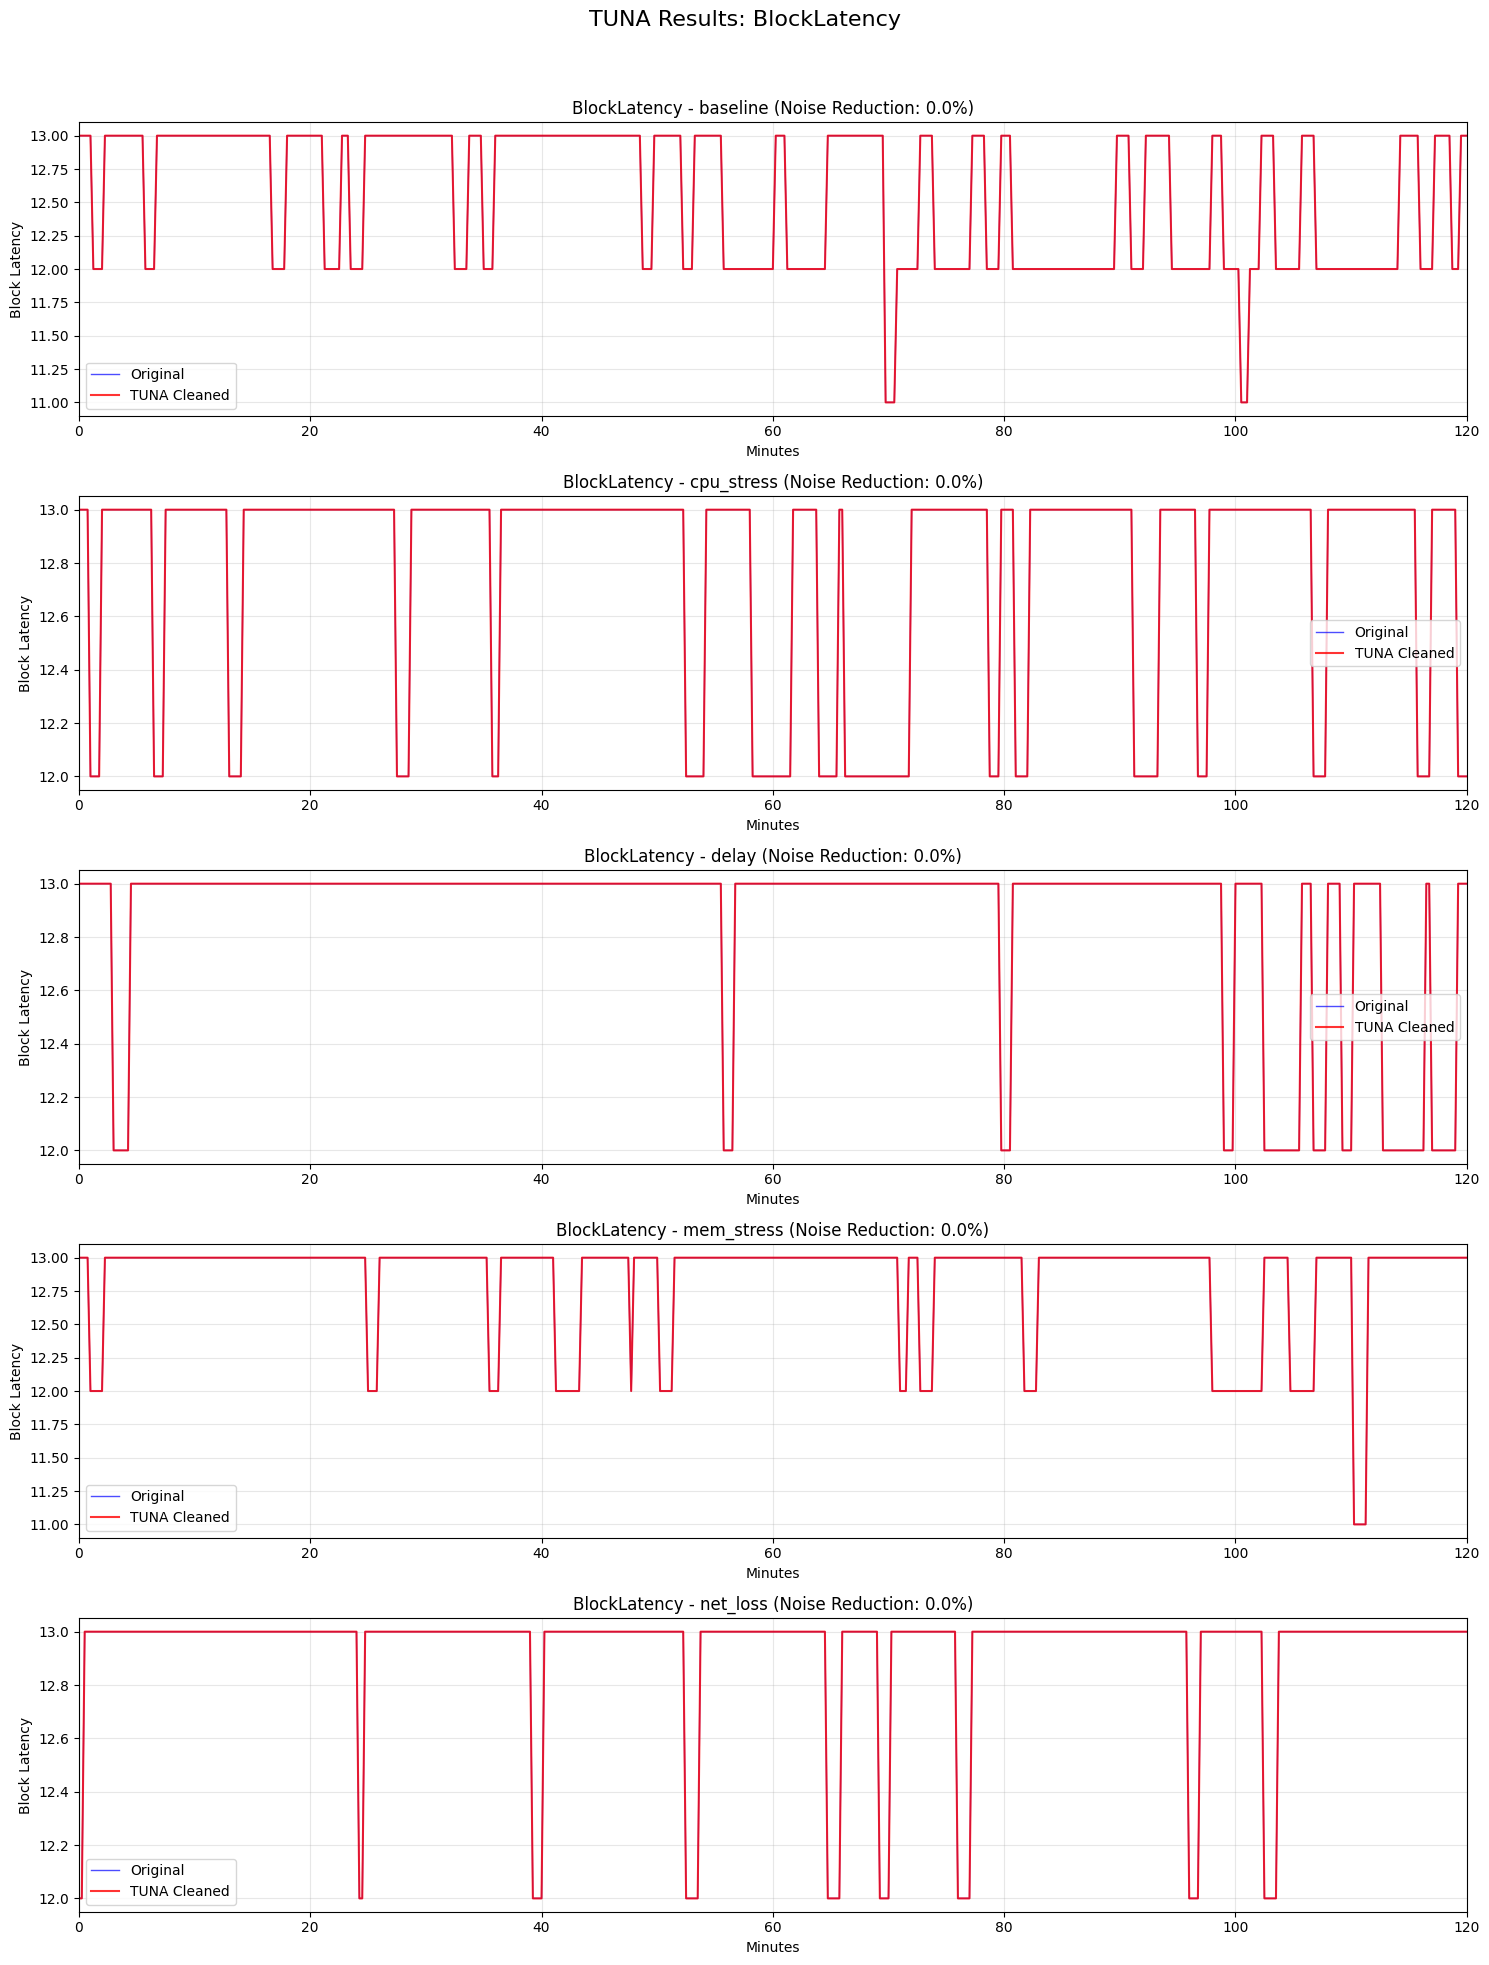

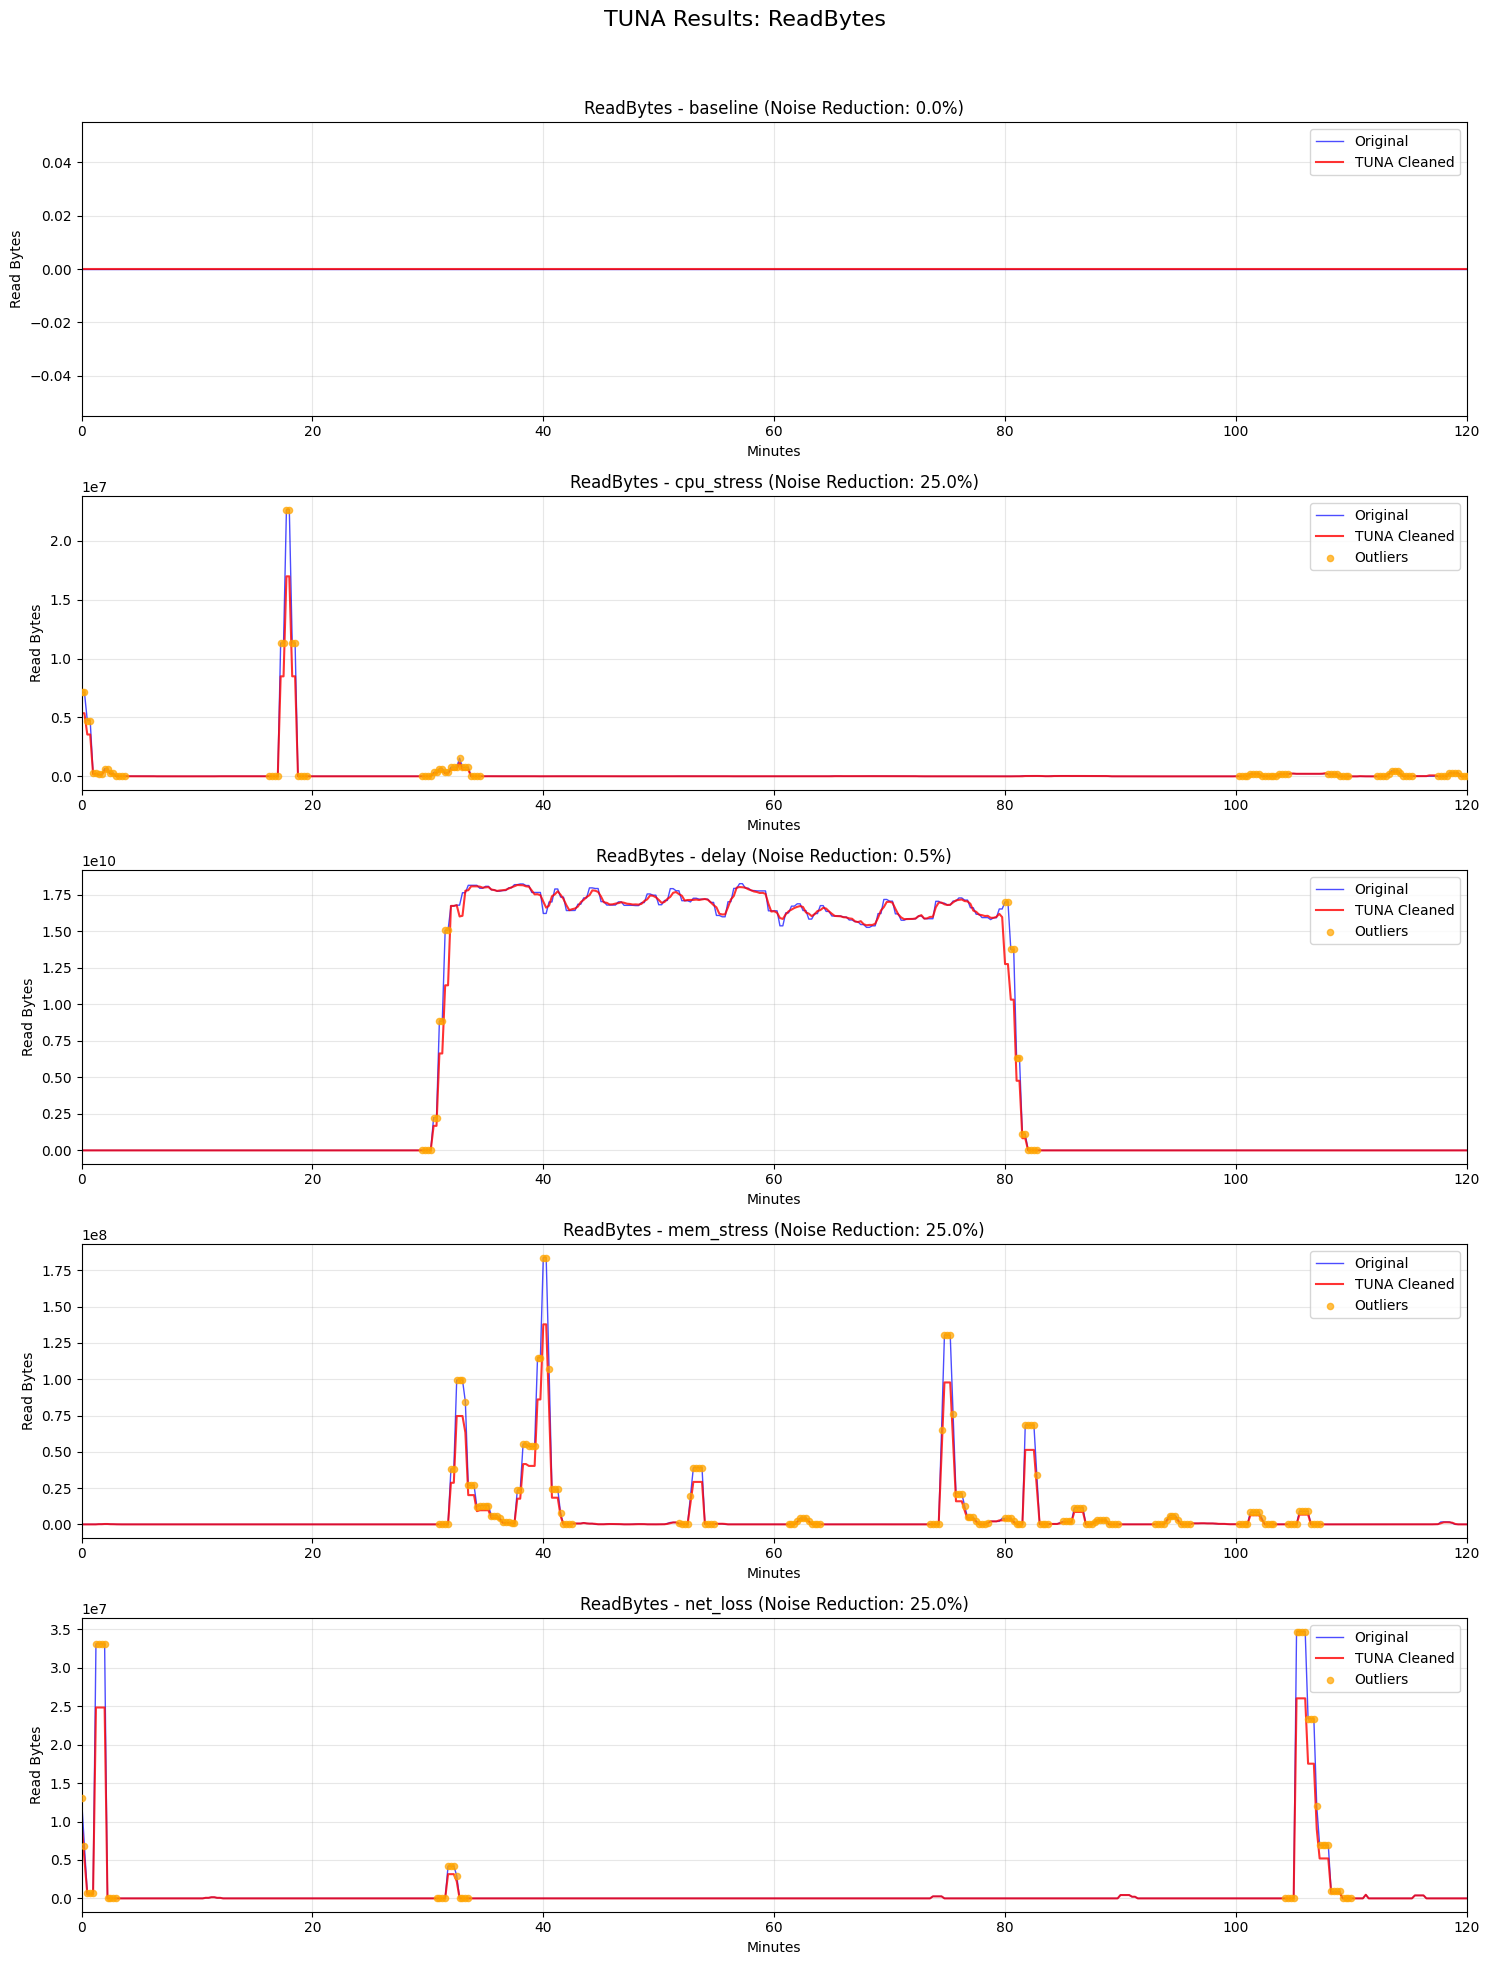

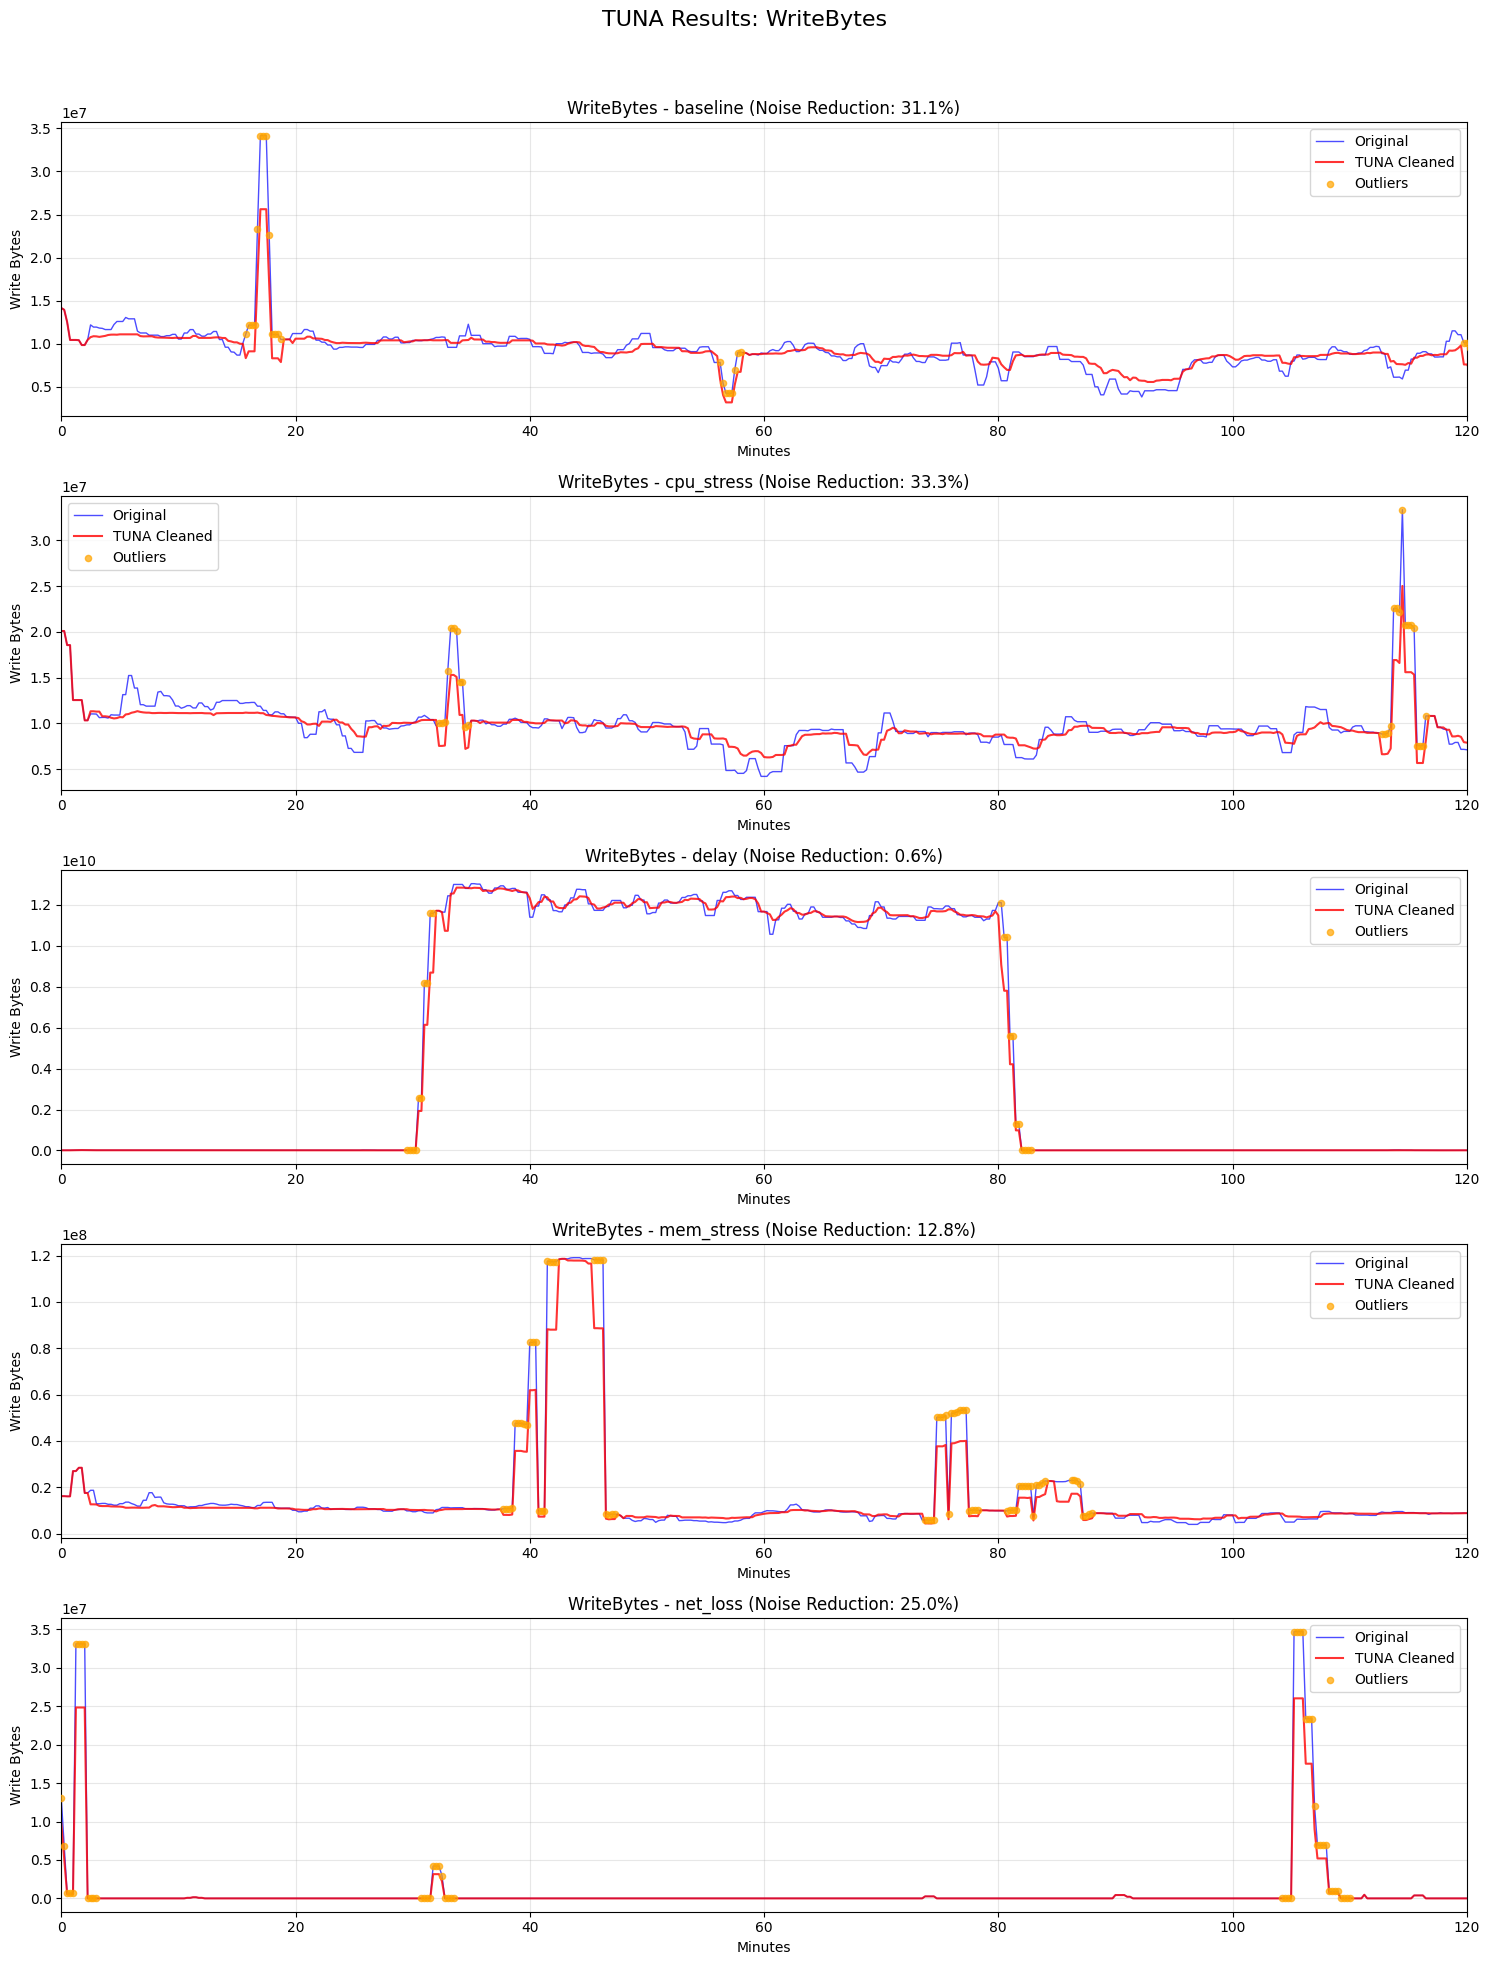


Disk I/O TUNA Results Summary:
Metric          Experiment   Outliers   Noise Red%   Correlation 
------------------------------------------------------------
BlockLatency    baseline     0                 0.0%       1.000
BlockLatency    cpu_stress   0                 0.0%       1.000
BlockLatency    delay        0                 0.0%       1.000
BlockLatency    mem_stress   0                 0.0%       1.000
BlockLatency    net_loss     0                 0.0%       1.000
ReadBytes       baseline     0                 0.0%         nan
ReadBytes       cpu_stress   101              25.0%       1.000
ReadBytes       delay        22                0.5%       0.998
ReadBytes       mem_stress   167              25.0%       1.000
ReadBytes       net_loss     49               25.0%       1.000
WriteBytes      baseline     26               31.1%       0.940
WriteBytes      cpu_stress   27               33.3%       0.913
WriteBytes      delay        21                0.6%       0.998
WriteByte

In [2]:
def extract_disk_values(df, metric_name):
    """Extract disk values - single column for DiskUtil, sum for ReadBytes/WriteBytes"""
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'DiskUtil':
        # For disk utilization, we typically have a single disk column
        if len(value_cols) == 1:
            return df[value_cols[0]].values
        else:
            # If multiple disks, take the primary one or sum (depending on use case)
            return df[value_cols[0]].values  # Take first disk as primary
    else:
        # For ReadBytes/WriteBytes, sum across all partitions/devices
        return df[value_cols].sum(axis=1).values

def detect_outliers_tuna(timeseries, window_size=5, threshold=0.65, min_absolute_range=None):
    """
    TUNA's relative range outlier detection with stability improvements
    Formula: (max - min) / mean > threshold
    Mark all values in unstable windows as outliers
    """
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    # Calculate adaptive minimum absolute range if not provided
    if min_absolute_range is None:
        # Use 5% of the overall time series standard deviation as minimum range
        min_absolute_range = 0.1 * np.std(timeseries)
    
    # Slide window across time series to detect unstable periods
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0:
            # Apply TUNA relative range criterion
            relative_range = window_range / window_mean
            
            # Additional filter: require minimum absolute range to avoid hypersensitivity
            if relative_range > threshold and window_range > min_absolute_range:
                # Mark all values within unstable window as outliers
                for j in range(window_size):
                    actual_idx = i + j
                    outlier_mask[actual_idx] = True
    
    return outlier_mask

def create_features_for_ml(timeseries, outlier_mask, experiment_type, window_size=10):
    """Create features for ML training using only stable values in history"""
    features = []
    
    # Extract temporal and statistical features from sliding windows of STABLE values only
    for i in range(window_size, len(timeseries)):
        # Get the last window_size values, but only use stable ones
        stable_history = []
        for j in range(i - window_size, i):
            if j >= 0 and not outlier_mask[j]:  # Only include stable values
                stable_history.append(timeseries[j])
        
        # If we don't have enough stable history, skip this prediction
        if len(stable_history) < 3:
            continue
            
        # Pad with last stable value if needed
        while len(stable_history) < window_size:
            stable_history.append(stable_history[-1])
        
        # Statistical features from stable history only
        stable_window = np.array(stable_history)
        feature_vector = [
            np.mean(stable_window),                    # Rolling average of stable values
            np.std(stable_window),                     # Variability of stable values
            np.median(stable_window),                  # Robust central tendency
            np.max(stable_window) - np.min(stable_window),  # Range of stable values
            stable_history[-1],                        # Last stable value
            i / len(timeseries),                       # Temporal position
        ]
        
        # Experiment context encoding
        exp_features = [0, 0, 0, 0, 0]
        if experiment_type == "baseline":
            exp_features[0] = 1
        elif experiment_type == "cpu_stress":
            exp_features[1] = 1
        elif experiment_type == "delay":
            exp_features[2] = 1
        elif experiment_type == "mem_stress":
            exp_features[3] = 1
        elif experiment_type == "net_loss":
            exp_features[4] = 1
        
        feature_vector.extend(exp_features)
        features.append((i, feature_vector))  # Store index with features
    
    return features

def train_random_forest_for_metric(metric_name, all_experiments):
    """Train RandomForest on stable periods across all experiments using stable-only features"""
    print(f"Training {metric_name}...")
    
    X_stable_all = []
    y_stable_all = []
    
    # Aggregate stable training data from all experimental conditions
    for exp_name, df in all_experiments.items():
        values = extract_disk_values(df, metric_name)
        outlier_mask = detect_outliers_tuna(values)
        
        # Create features using only stable history
        indexed_features = create_features_for_ml(values, outlier_mask, exp_name)
        
        for idx, feature_vector in indexed_features:
            if not outlier_mask[idx]:  # Only train on stable targets
                X_stable_all.append(feature_vector)
                y_stable_all.append(values[idx])
    
    # Ensure sufficient training data
    if len(X_stable_all) < 10:
        return None, None
    
    X_stable_all = np.array(X_stable_all)
    y_stable_all = np.array(y_stable_all)
    
    # Standardize features for optimal model performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_stable_all)

    # Hyperparameter grid for model optimization
    param_grid = {
        'n_estimators': [100],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    model = RandomForestRegressor(
        criterion='squared_error',
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # Grid search with cross-validation for robust parameter selection
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_scaled, y_stable_all)
    model = grid_search.best_estimator_
    
    return model, scaler

def apply_penalty(timeseries, outlier_mask, penalty_factor=0.75):
    """Apply penalty to outliers by reducing their magnitude"""
    cleaned_series = timeseries.copy()
    
    # Apply penalty exactly once to each outlier
    outlier_indices = np.where(outlier_mask)[0]
    for i in outlier_indices:
        original_value = timeseries[i]
        if original_value != 0:  # Only apply penalty to non-zero values
            # Simple penalty: reduce magnitude by factor
            cleaned_series[i] = original_value * penalty_factor
        # Zero values remain zero (no penalty needed)
    
    return cleaned_series

def apply_tuna_to_single_series(values, exp_name, model, scaler, penalty_factor=0.75, blend_weight=1.0, metric_name=""):
    """Apply TUNA cleaning to a single time series with stable-history ML + penalty"""
    
    # Check data characteristics for smart ML application
    unique_values = len(np.unique(values))
    data_range = np.max(values) - np.min(values)
    zero_percentage = np.sum(values == 0) / len(values) * 100
    
    # Enhanced discrete data detection
    is_discrete_data = (
        unique_values <= 10 and data_range <= 50  # Low variety and range
        or zero_percentage > 60  # High percentage of zeros
        or (unique_values <= 20 and all(x == int(x) for x in np.unique(values) if not np.isnan(x)))  # All integers
    )
    
    outlier_mask = detect_outliers_tuna(values, window_size=5, threshold=0.65)
    
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    # Phase 2: Apply penalty to outliers FIRST
    cleaned_series = apply_penalty(values, outlier_mask, penalty_factor)
    
    # Phase 3: Apply ML enhancement using stable history only
    if not is_discrete_data and model is not None and scaler is not None:
        try:
            # Create features using only stable history
            indexed_features = create_features_for_ml(values, outlier_mask, exp_name)
            
            for idx, feature_vector in indexed_features:
                if stable_mask[idx]:  # Only predict for stable periods
                    try:
                        features_scaled = scaler.transform([feature_vector])
                        ml_prediction = model.predict(features_scaled)[0]
                        cleaned_series[idx] = ml_prediction
                    except:
                        # If prediction fails, keep the penalty-adjusted value
                        pass
            
            # Ensure non-negative values for count data
            cleaned_series = np.maximum(0, cleaned_series)
            
            print(f"  ✓ Applied stable-history ML + penalty (factor: {penalty_factor}) for {metric_name} - {exp_name}")
            
        except Exception as e:
            print(f"  ⚠ ML enhancement failed for {metric_name} - {exp_name}: {str(e)}")
    else:
        if is_discrete_data:
            print(f"  ℹ Applied penalty-only (factor: {penalty_factor}) for {metric_name} - {exp_name} (discrete data)")
        else:
            print(f"  ℹ Applied penalty-only (factor: {penalty_factor}) for {metric_name} - {exp_name} (no model)")
    
    # Calculate cleaning statistics
    original_std = np.std(values)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
    correlation = np.corrcoef(values, cleaned_series)[0, 1] if len(values) > 1 else 1.0
    
    cleaning_stats = {
        'outliers': outliers_count,
        'outlier_percentage': (outliers_count / len(values)) * 100,
        'noise_reduction': noise_reduction,
        'correlation': correlation,
        'mean_before': np.mean(values),
        'mean_after': np.mean(cleaned_series),
        'std_before': original_std,
        'std_after': cleaned_std,
        'zero_percentage': zero_percentage,
        'unique_values': unique_values,
        'data_type': 'discrete' if is_discrete_data else 'continuous',
        'penalty_factor': penalty_factor
    }
    
    return cleaned_series, outlier_mask, cleaning_stats

def run_tuna_for_all_metrics():
    """Run TUNA for all disk metrics"""
    print("Running TUNA analysis on disk I/O datasets...")
    
    tuna_results = {}
    
    # Process each disk metric independently
    for metric_name, experiments in all_datasets.items():
        print(f"Processing {metric_name}")
        
        # Train metric-specific model on cross-experiment stable data
        model, scaler = train_random_forest_for_metric(metric_name, experiments)
        
        # Apply cleaning to each experimental condition
        metric_results = {}
        for exp_name, df in experiments.items():
            values = extract_disk_values(df, metric_name)
            cleaned_series, outlier_mask, stats = apply_tuna_to_single_series(
                values, exp_name, model, scaler, metric_name=metric_name
            )
            
            metric_results[exp_name] = {
                'original': values,
                'cleaned': cleaned_series,
                'outliers': outlier_mask,
                'stats': stats
            }
        
        tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results(tuna_results):
    """Plot TUNA results with original vs cleaned comparison using Minutes (0-120) x-axis"""
    
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        # Visualize cleaning results for each experiment
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            # Get the corresponding dataframe to extract Minutes column
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            # Plot time series with cleaning overlay using Minutes as x-axis
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            # Highlight detected outliers
            outlier_points = np.where(outliers)[0]
            if len(outlier_points) > 0:
                axes[i].scatter(minutes[outlier_points], original[outlier_points], 
                               c='orange', s=20, alpha=0.7, label='Outliers', zorder=5)
            
            # Set appropriate y-axis label based on metric
            if 'block' in metric_name.lower() or 'latency' in metric_name.lower():
                y_label = 'Block Latency'
            elif 'read' in metric_name.lower():
                y_label = 'Read Bytes'
            elif 'write' in metric_name.lower():
                y_label = 'Write Bytes'
            else:
                y_label = 'Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%)')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)  # Set x-axis to match your experiment duration
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_tuna_summary(tuna_results):
    """Print summary table of cleaning effectiveness"""
    print("\nDisk I/O TUNA Results Summary:")
    print("="*60)
    print(f"{'Metric':<15} {'Experiment':<12} {'Outliers':<10} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*60)
    
    # Tabulate results across all metrics and experiments
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            print(f"{metric_name:<15} {exp_name:<12} {stats['outliers']:<10} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

# Execute complete TUNA analysis pipeline
tuna_results = run_tuna_for_all_metrics()
plot_tuna_results(tuna_results)
print_tuna_summary(tuna_results)


COMPREHENSIVE DISK I/O ANALYSIS
Each disk metric will be compared to its own baseline

🔍 Analyzing BlockLatency...

📊 Comparing BlockLatency: cpu_stress stress vs baseline


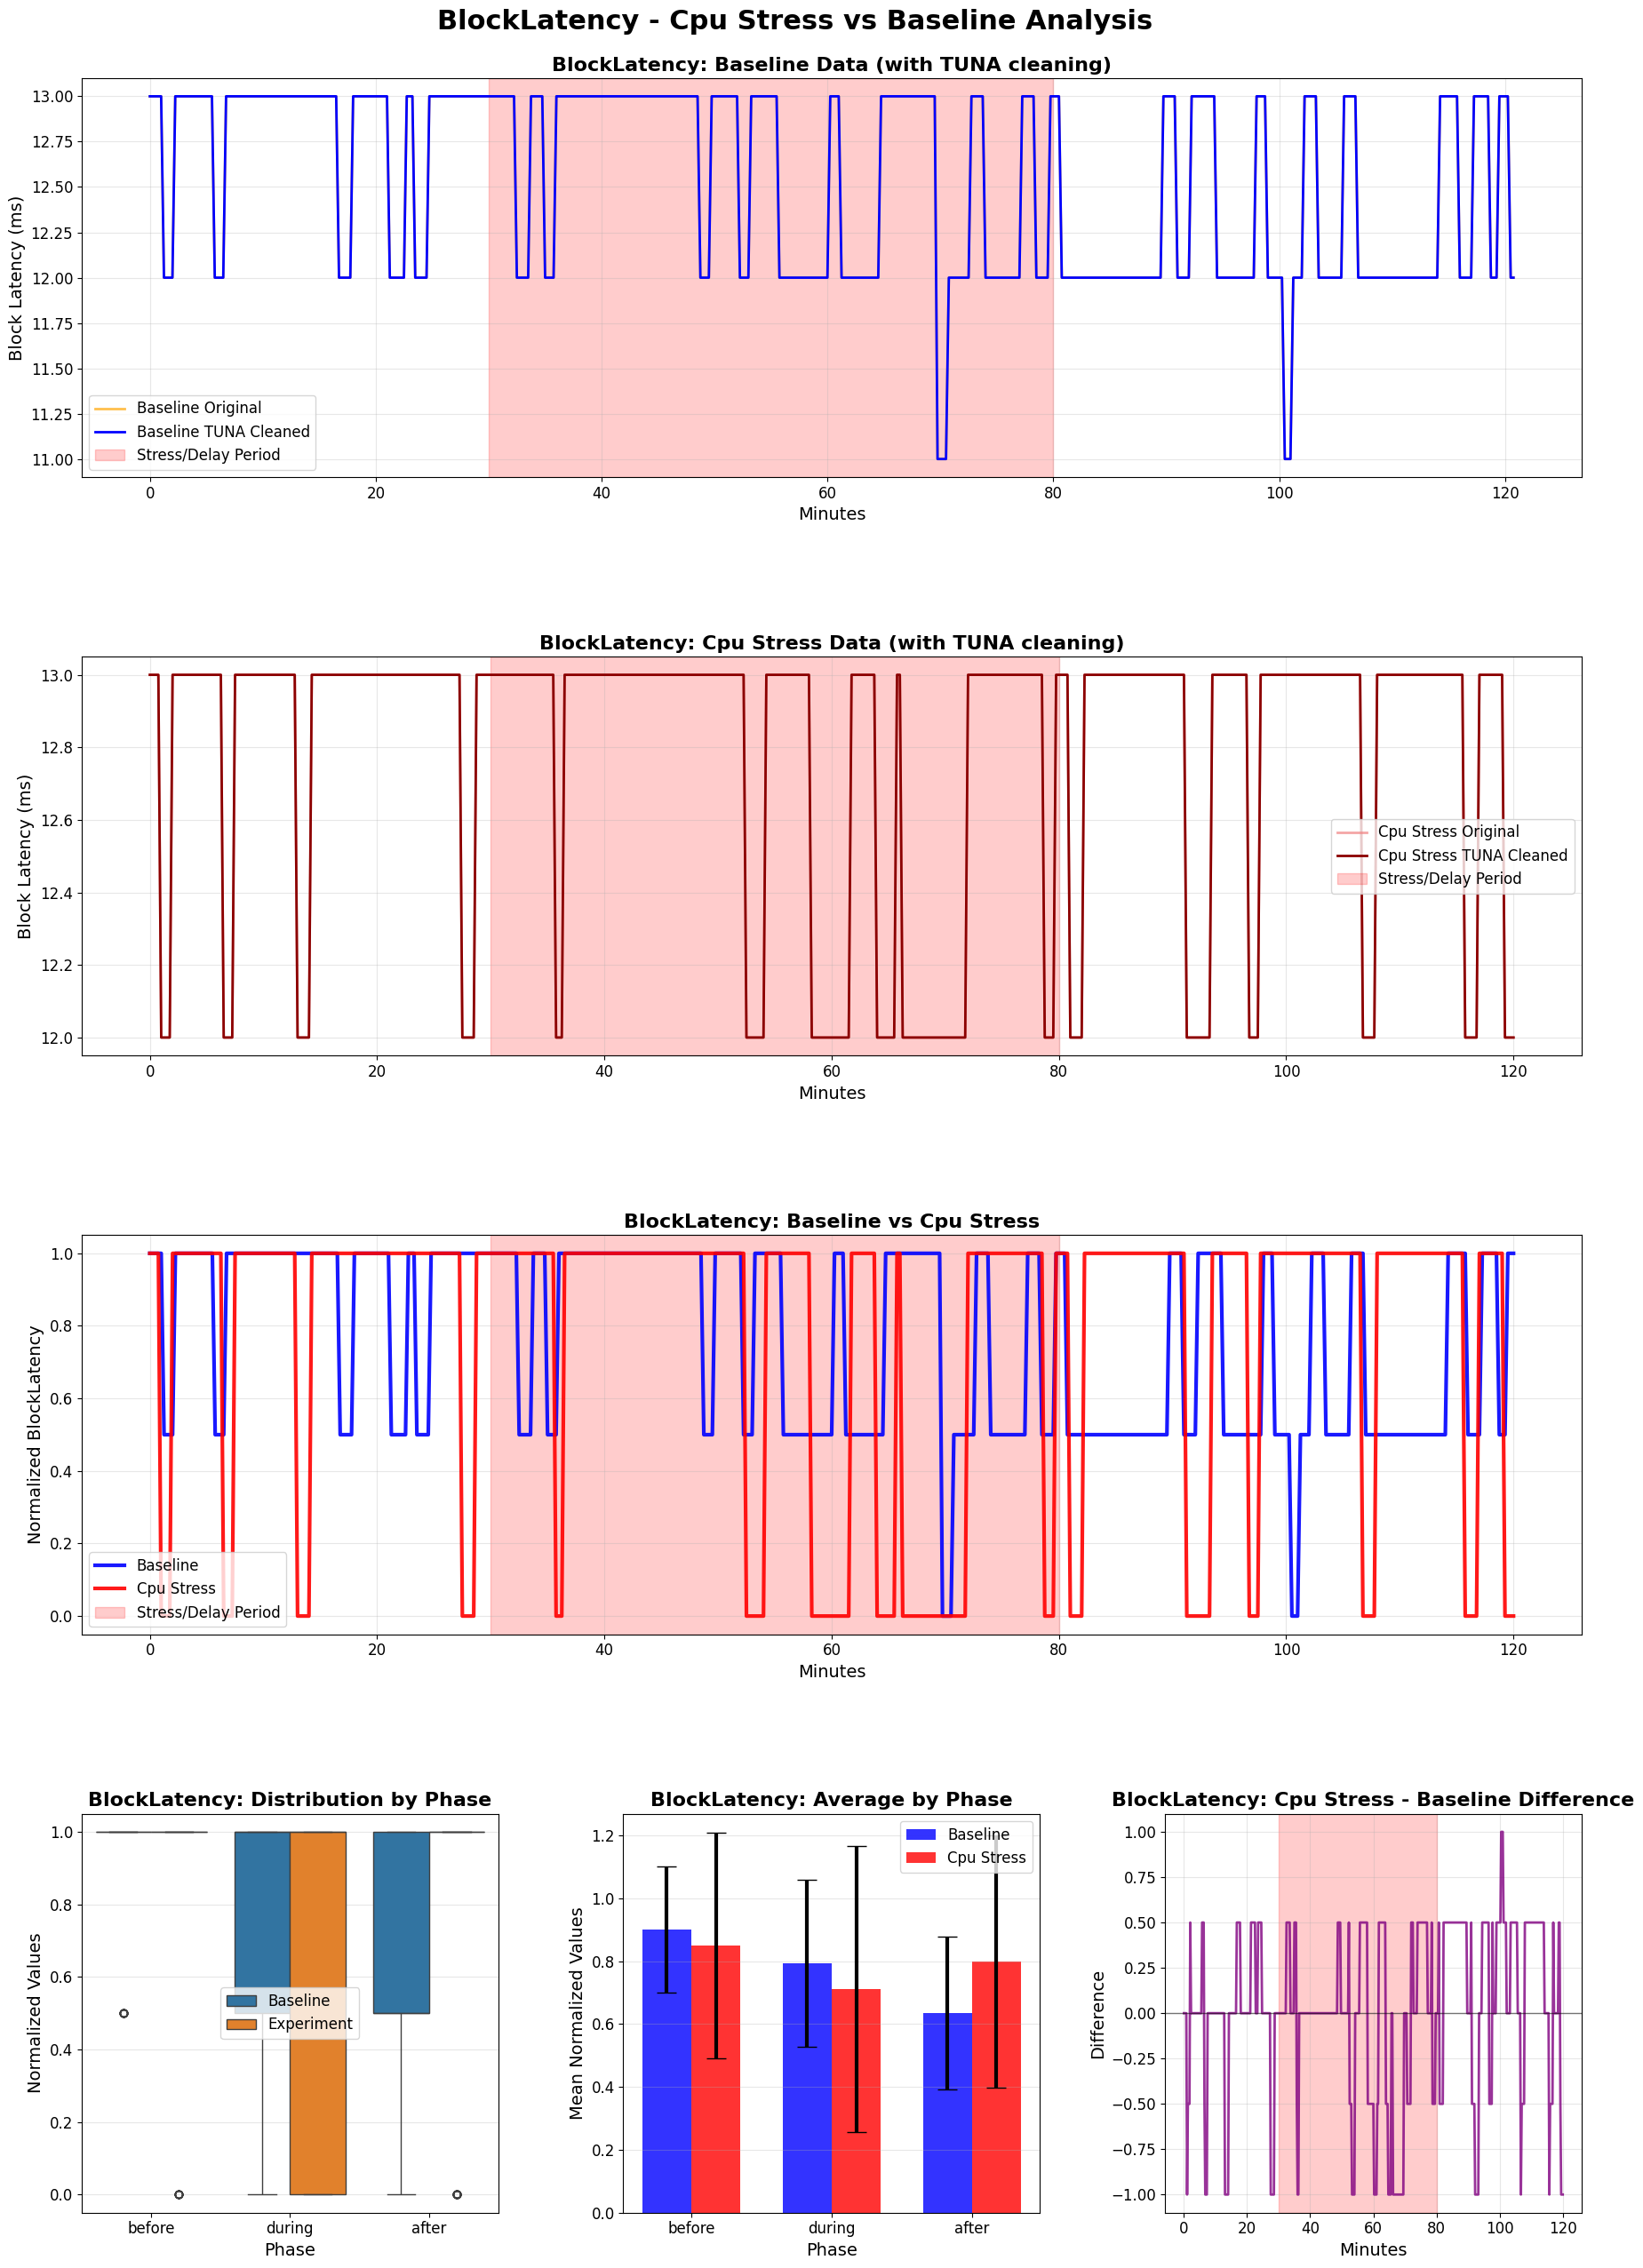


BLOCKLATENCY - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6344  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8000  0.4013  0.0  1.0
before  0.8500  0.3586  0.0  1.0
during  0.7114  0.4542  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  1.33, p=  0.1839 (NOT SIGNIFICANT)
  DURING  : t=  2.21, p=  0.0276 (SIGNIFICANT)
  AFTER   : t= -4.47, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   -5.56% (DECREASE)
  DURING  :  -10.34% (DECREASE)
  AFTER   :  +26.11% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)


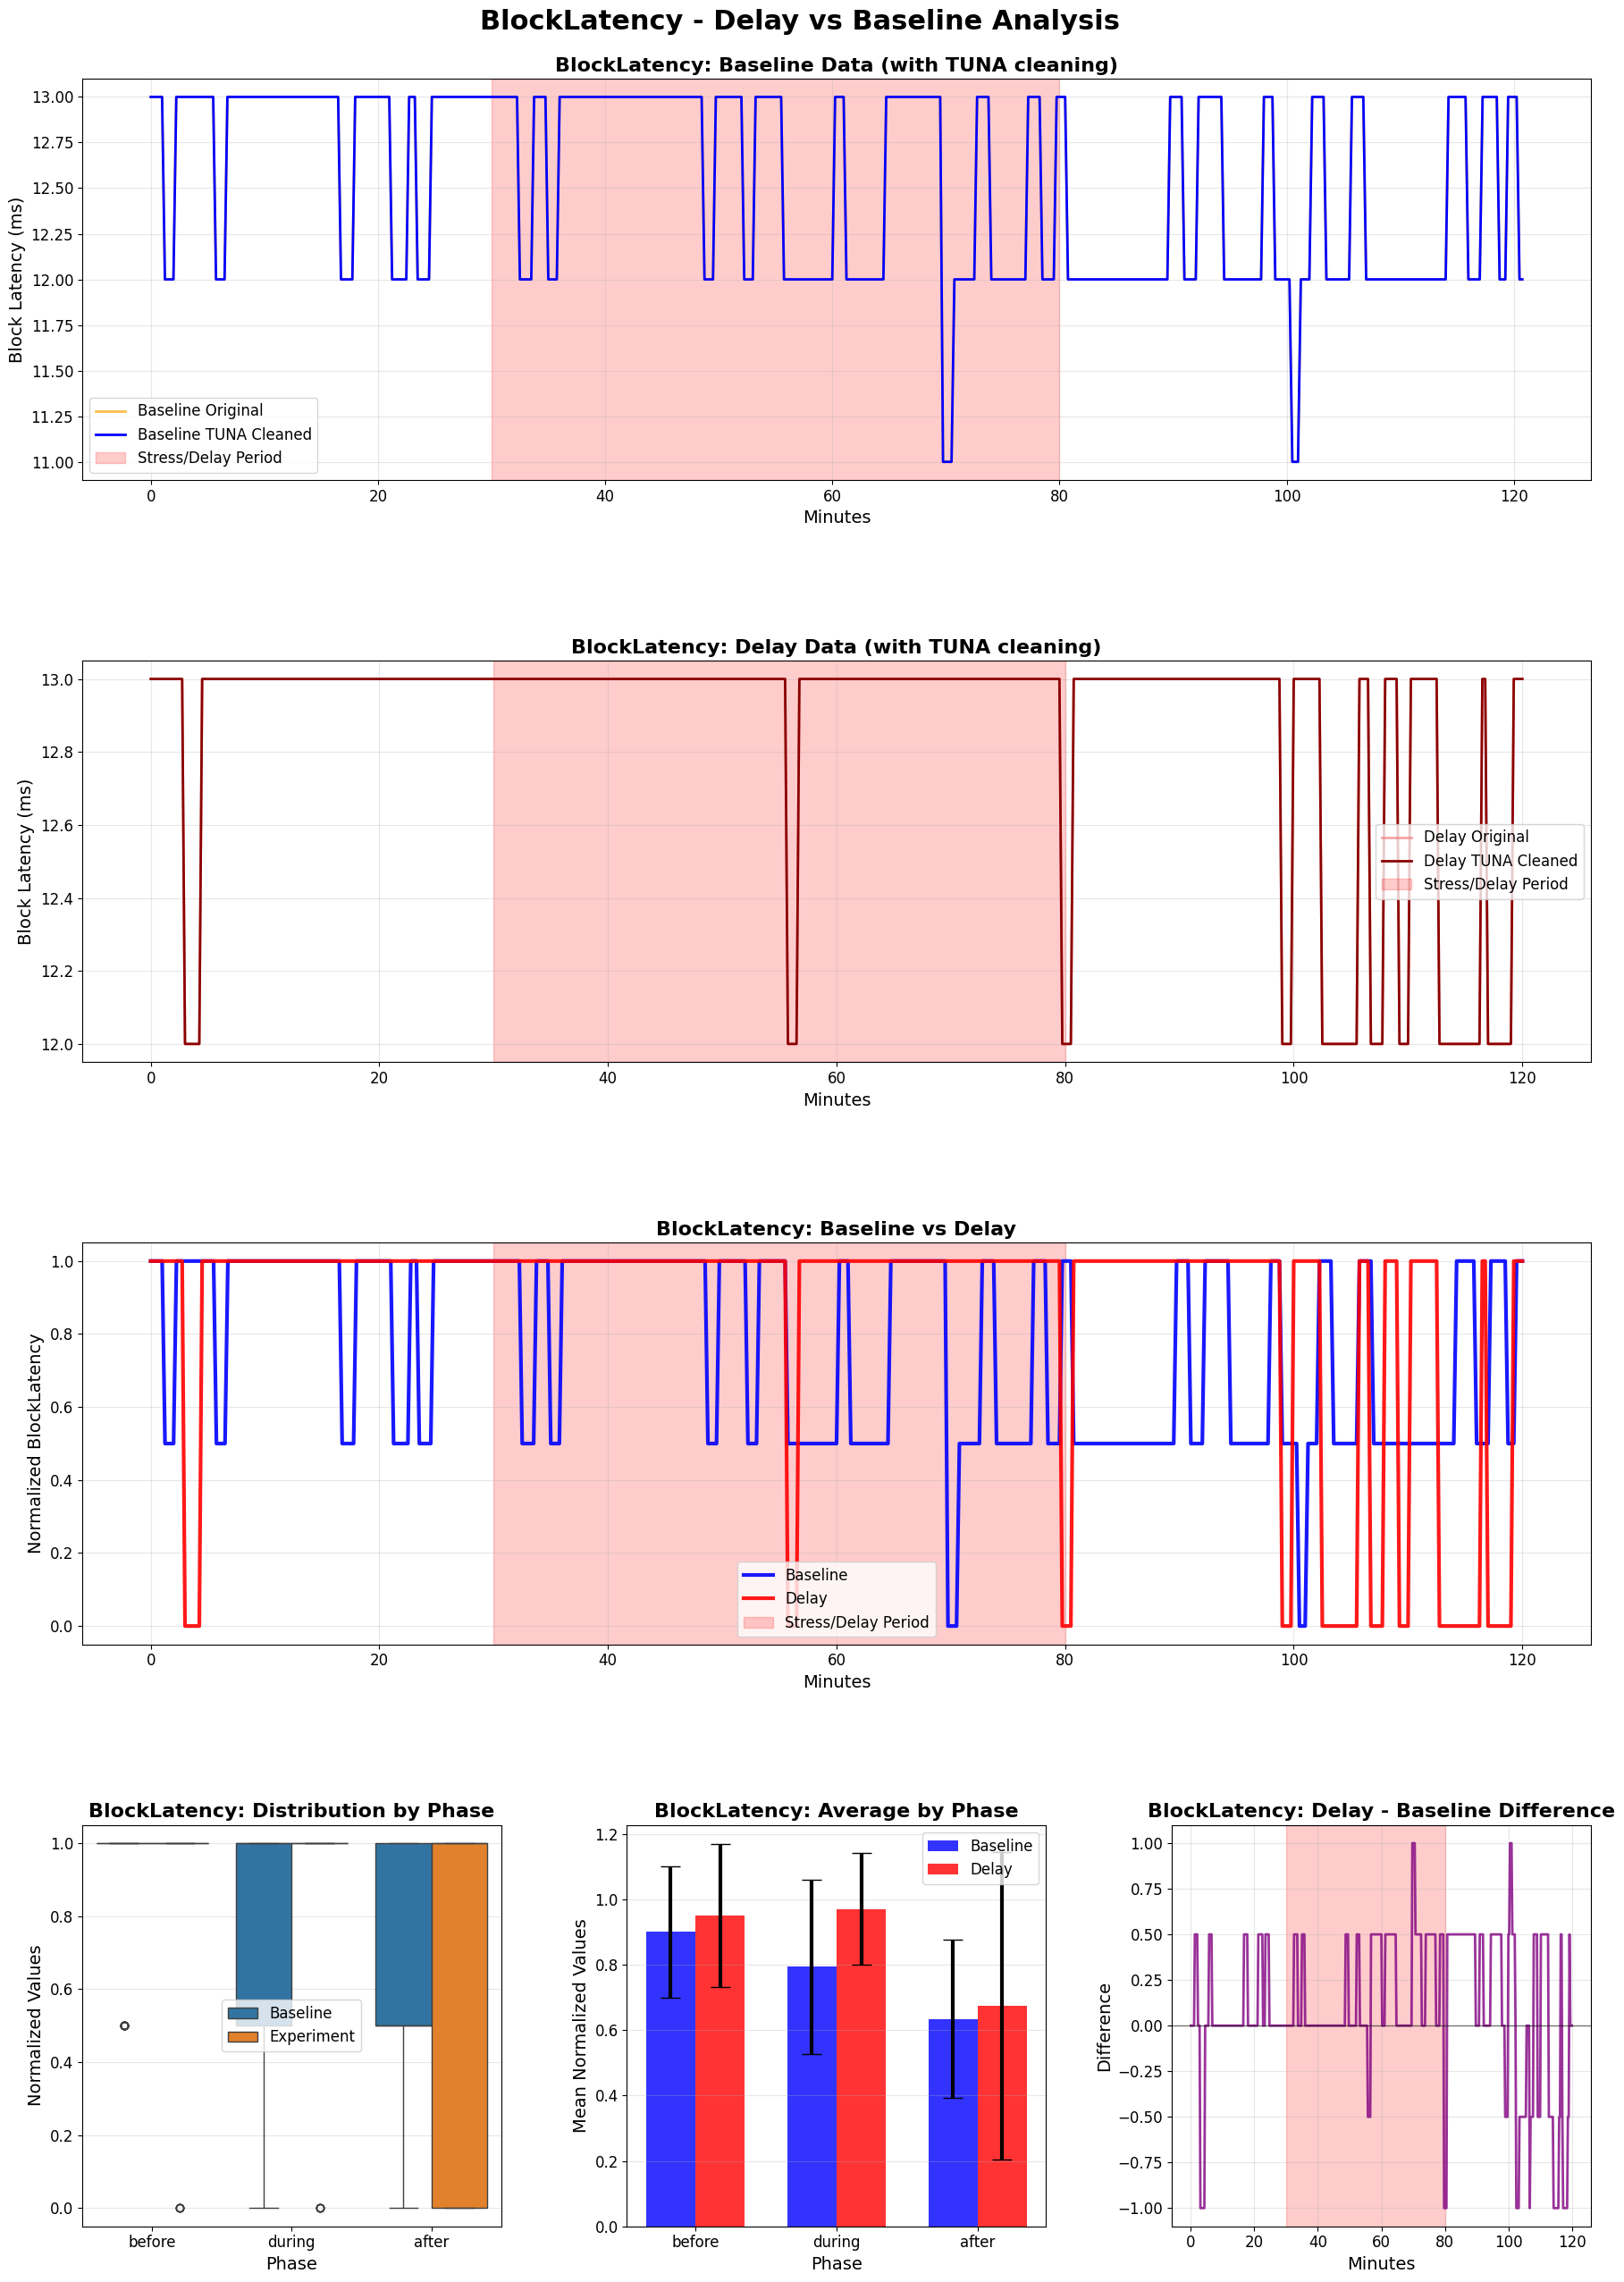


BLOCKLATENCY - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6344  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

DELAY STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6750  0.4698  0.0  1.0
before  0.9500  0.2189  0.0  1.0
during  0.9701  0.1706  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.84, p=  0.0664 (NOT SIGNIFICANT)
  DURING  : t= -7.92, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -0.97, p=  0.3319 (NOT SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +5.56% (INCREASE)
  DURING  :  +22.26% (INCREASE)
  AFTER   :   +6.40% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyz

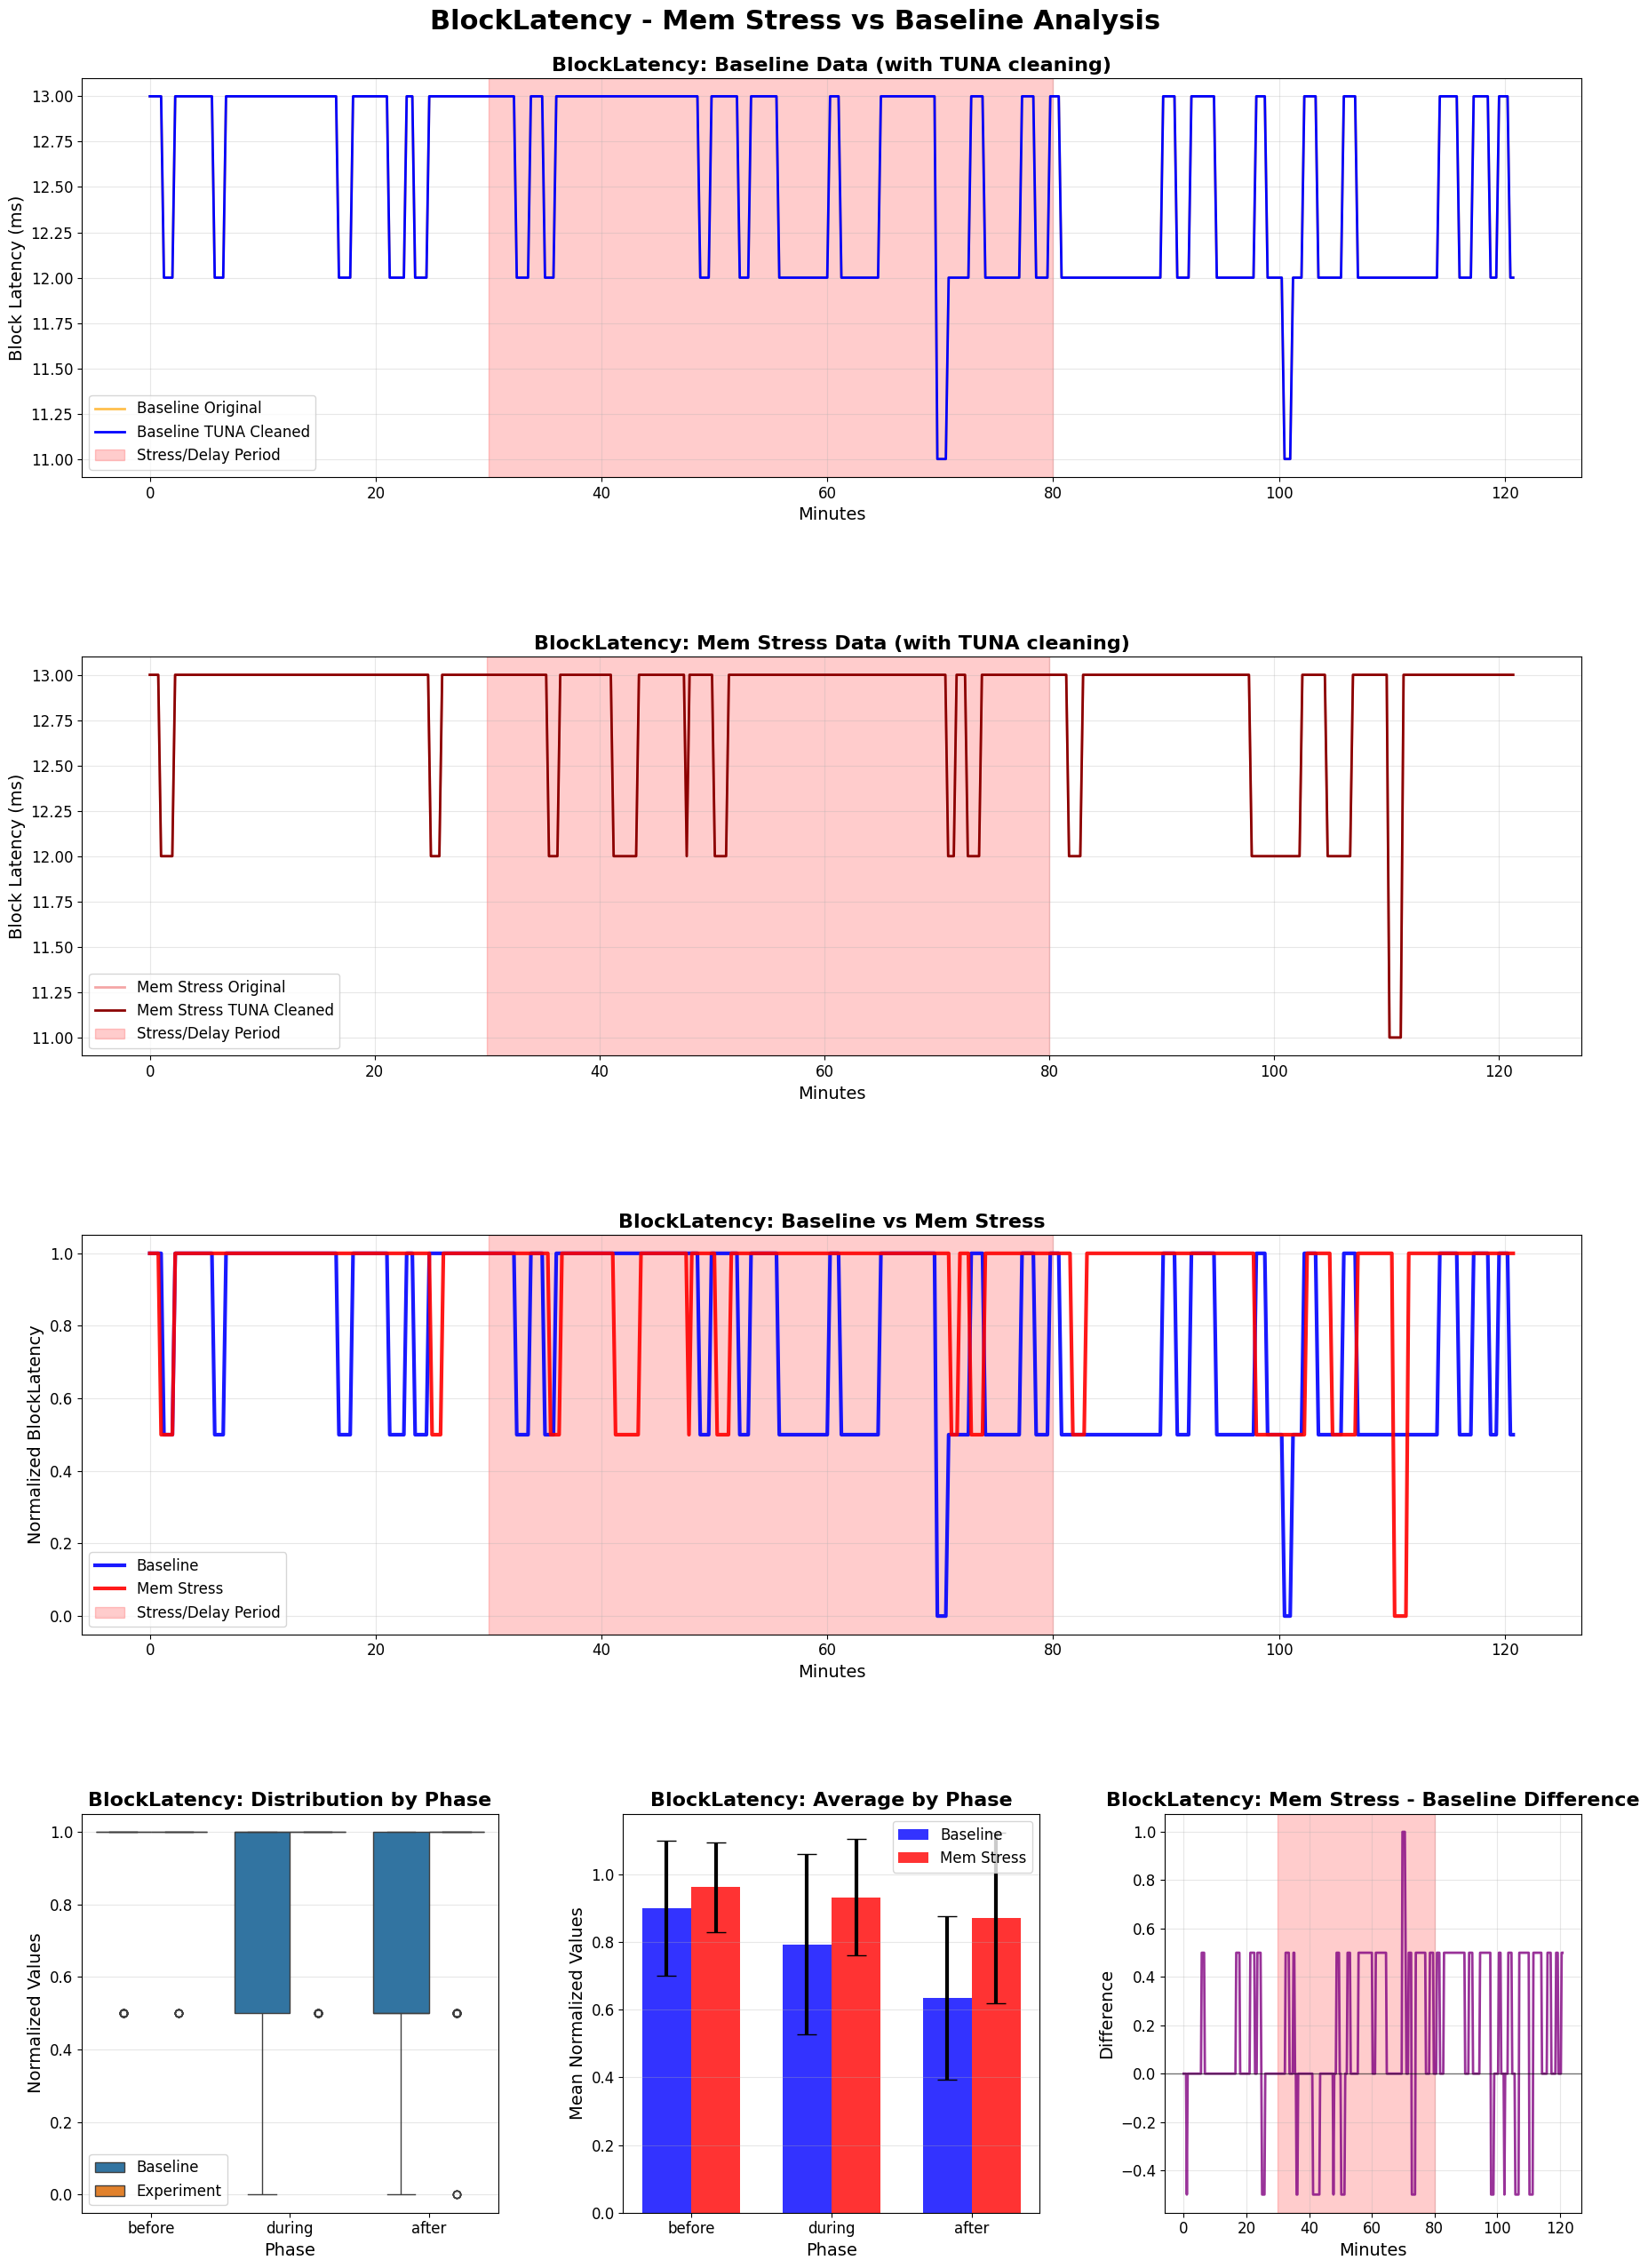


BLOCKLATENCY - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8712  0.2521  0.0  1.0
before  0.9625  0.1322  0.5  1.0
during  0.9328  0.1709  0.5  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.85, p=  0.0048 (SIGNIFICANT)
  DURING  : t= -6.24, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -8.62, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +6.94% (INCREASE)
  DURING  :  +17.55% (INCREASE)
  AFTER   :  +37.20% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Co

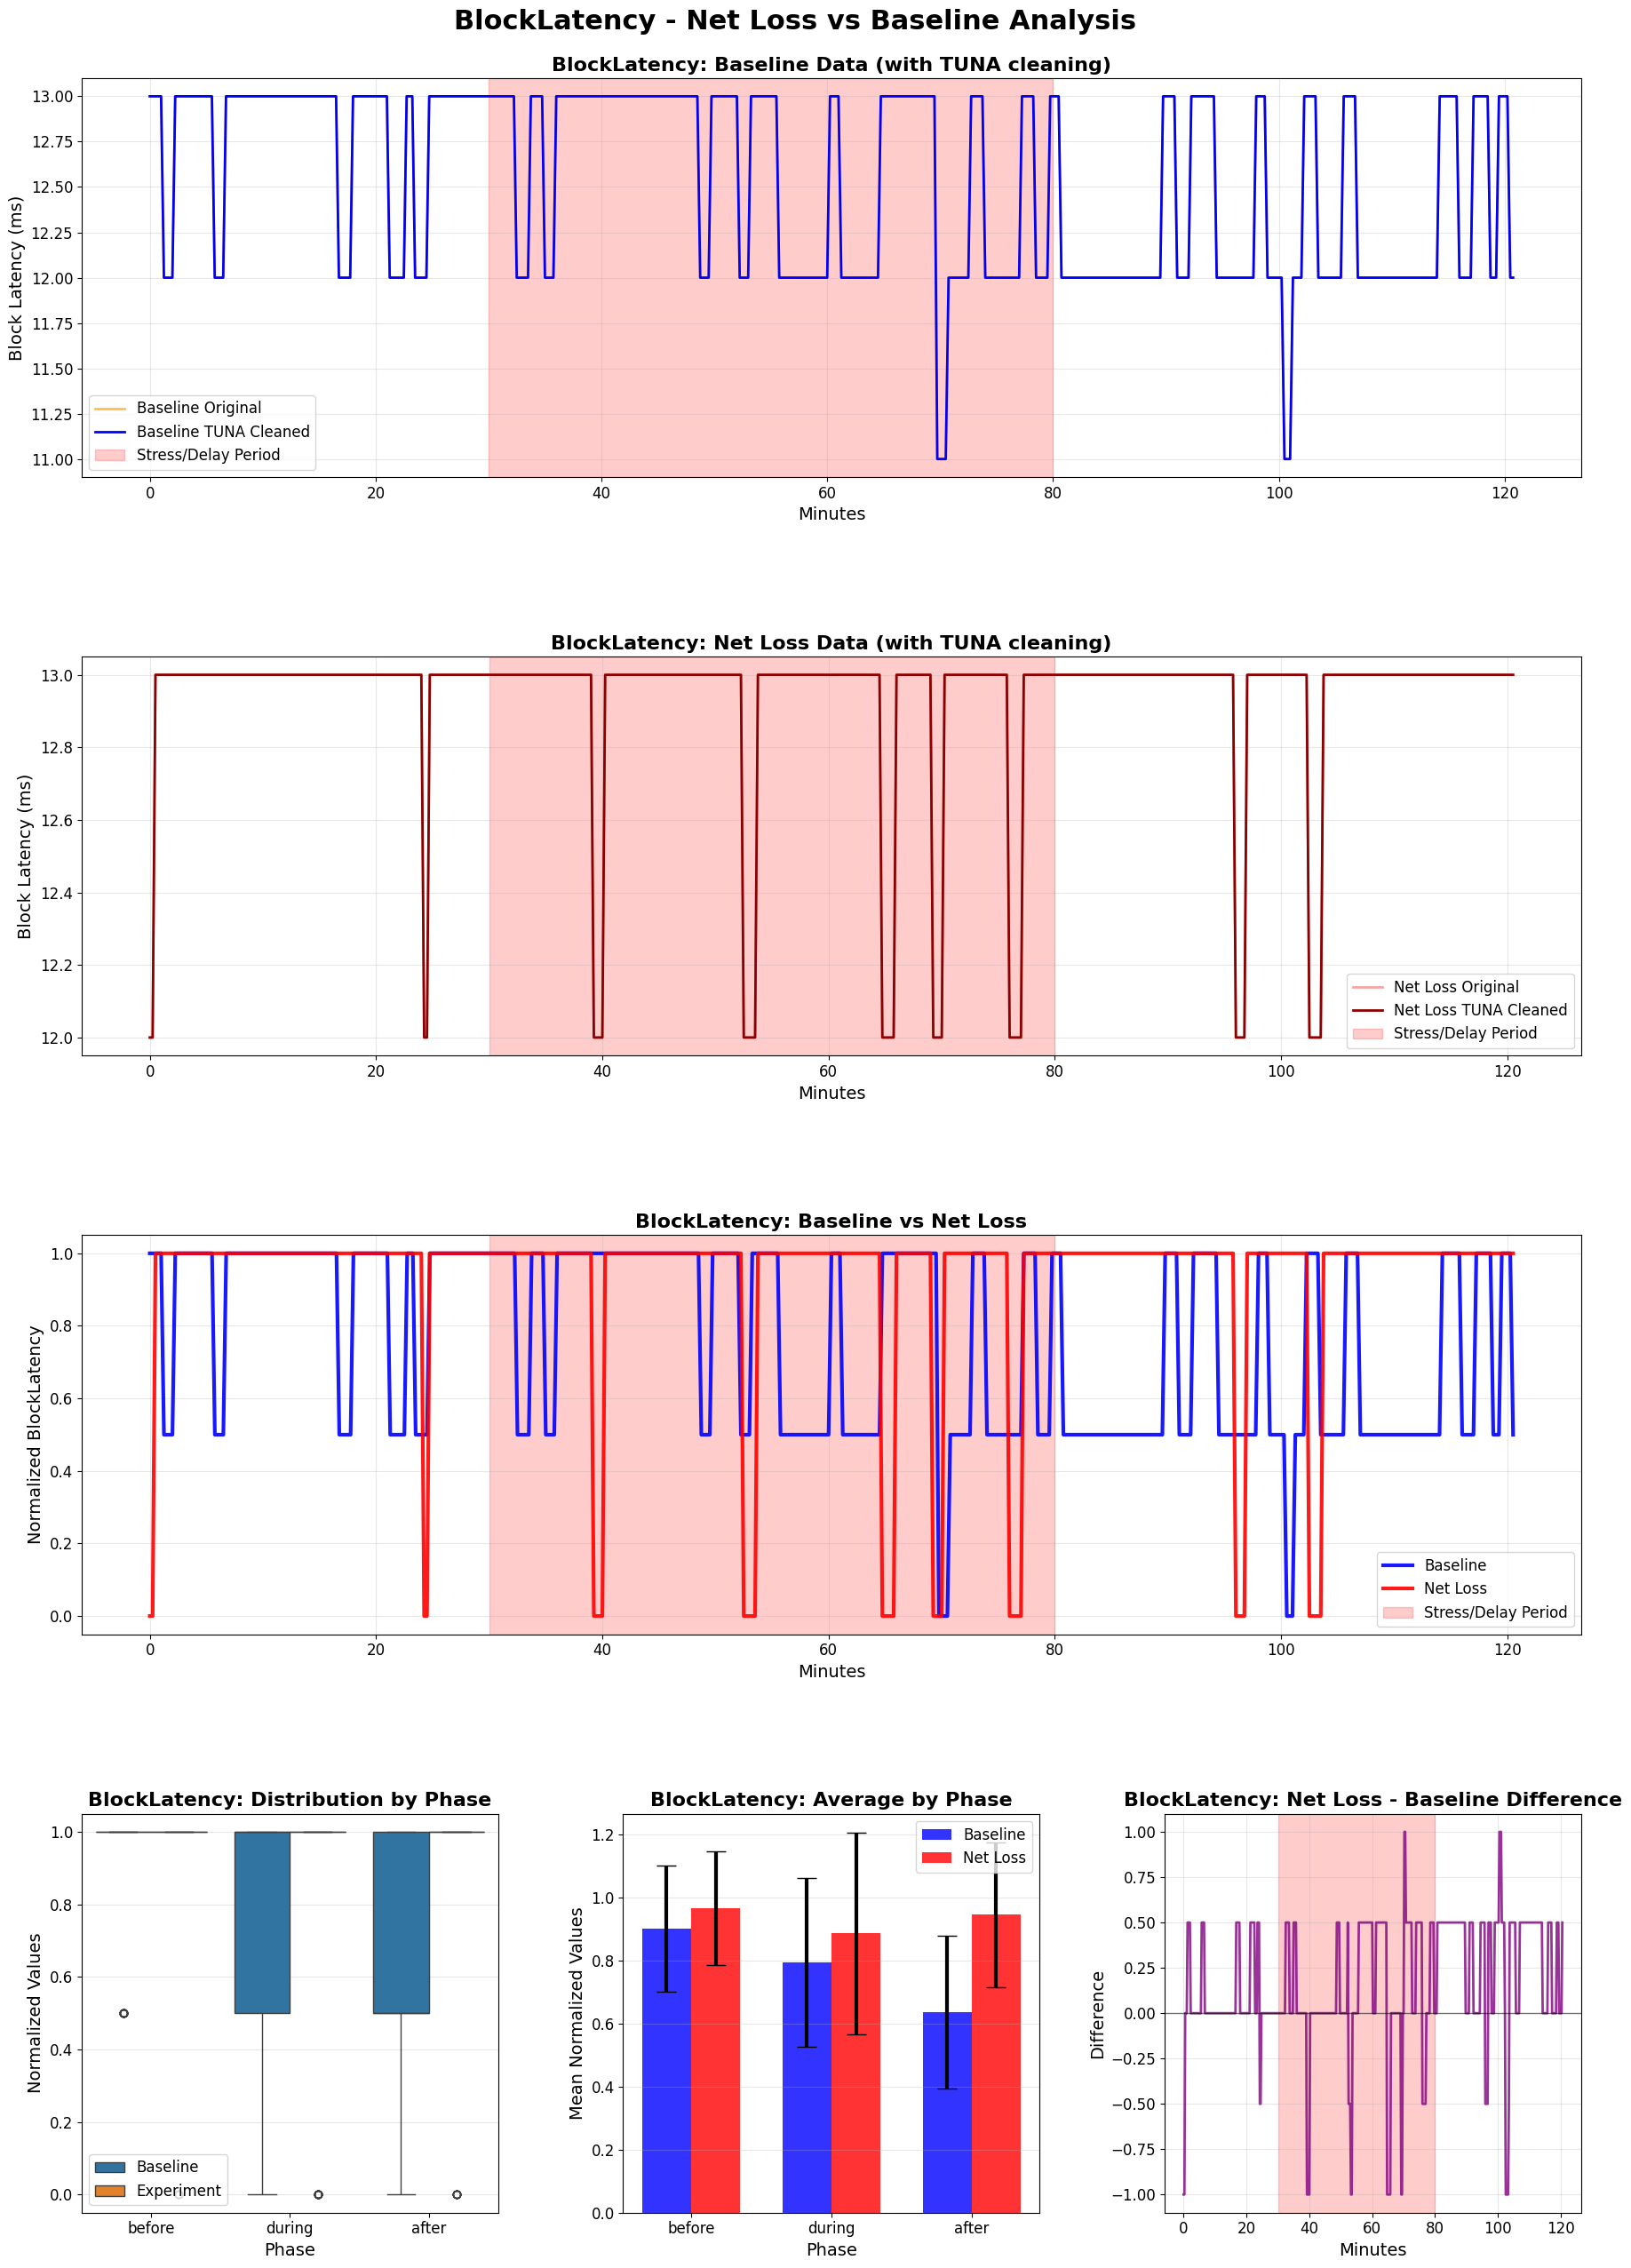


BLOCKLATENCY - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6358  0.2431  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.9444  0.2298  0.0  1.0
before  0.9667  0.1803  0.0  1.0
during  0.8856  0.3191  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.71, p=  0.0073 (SIGNIFICANT)
  DURING  : t= -3.14, p=  0.0018 (SIGNIFICANT)
  AFTER   : t=-11.74, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +7.41% (INCREASE)
  DURING  :  +11.60% (INCREASE)
  AFTER   :  +48.54% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns an

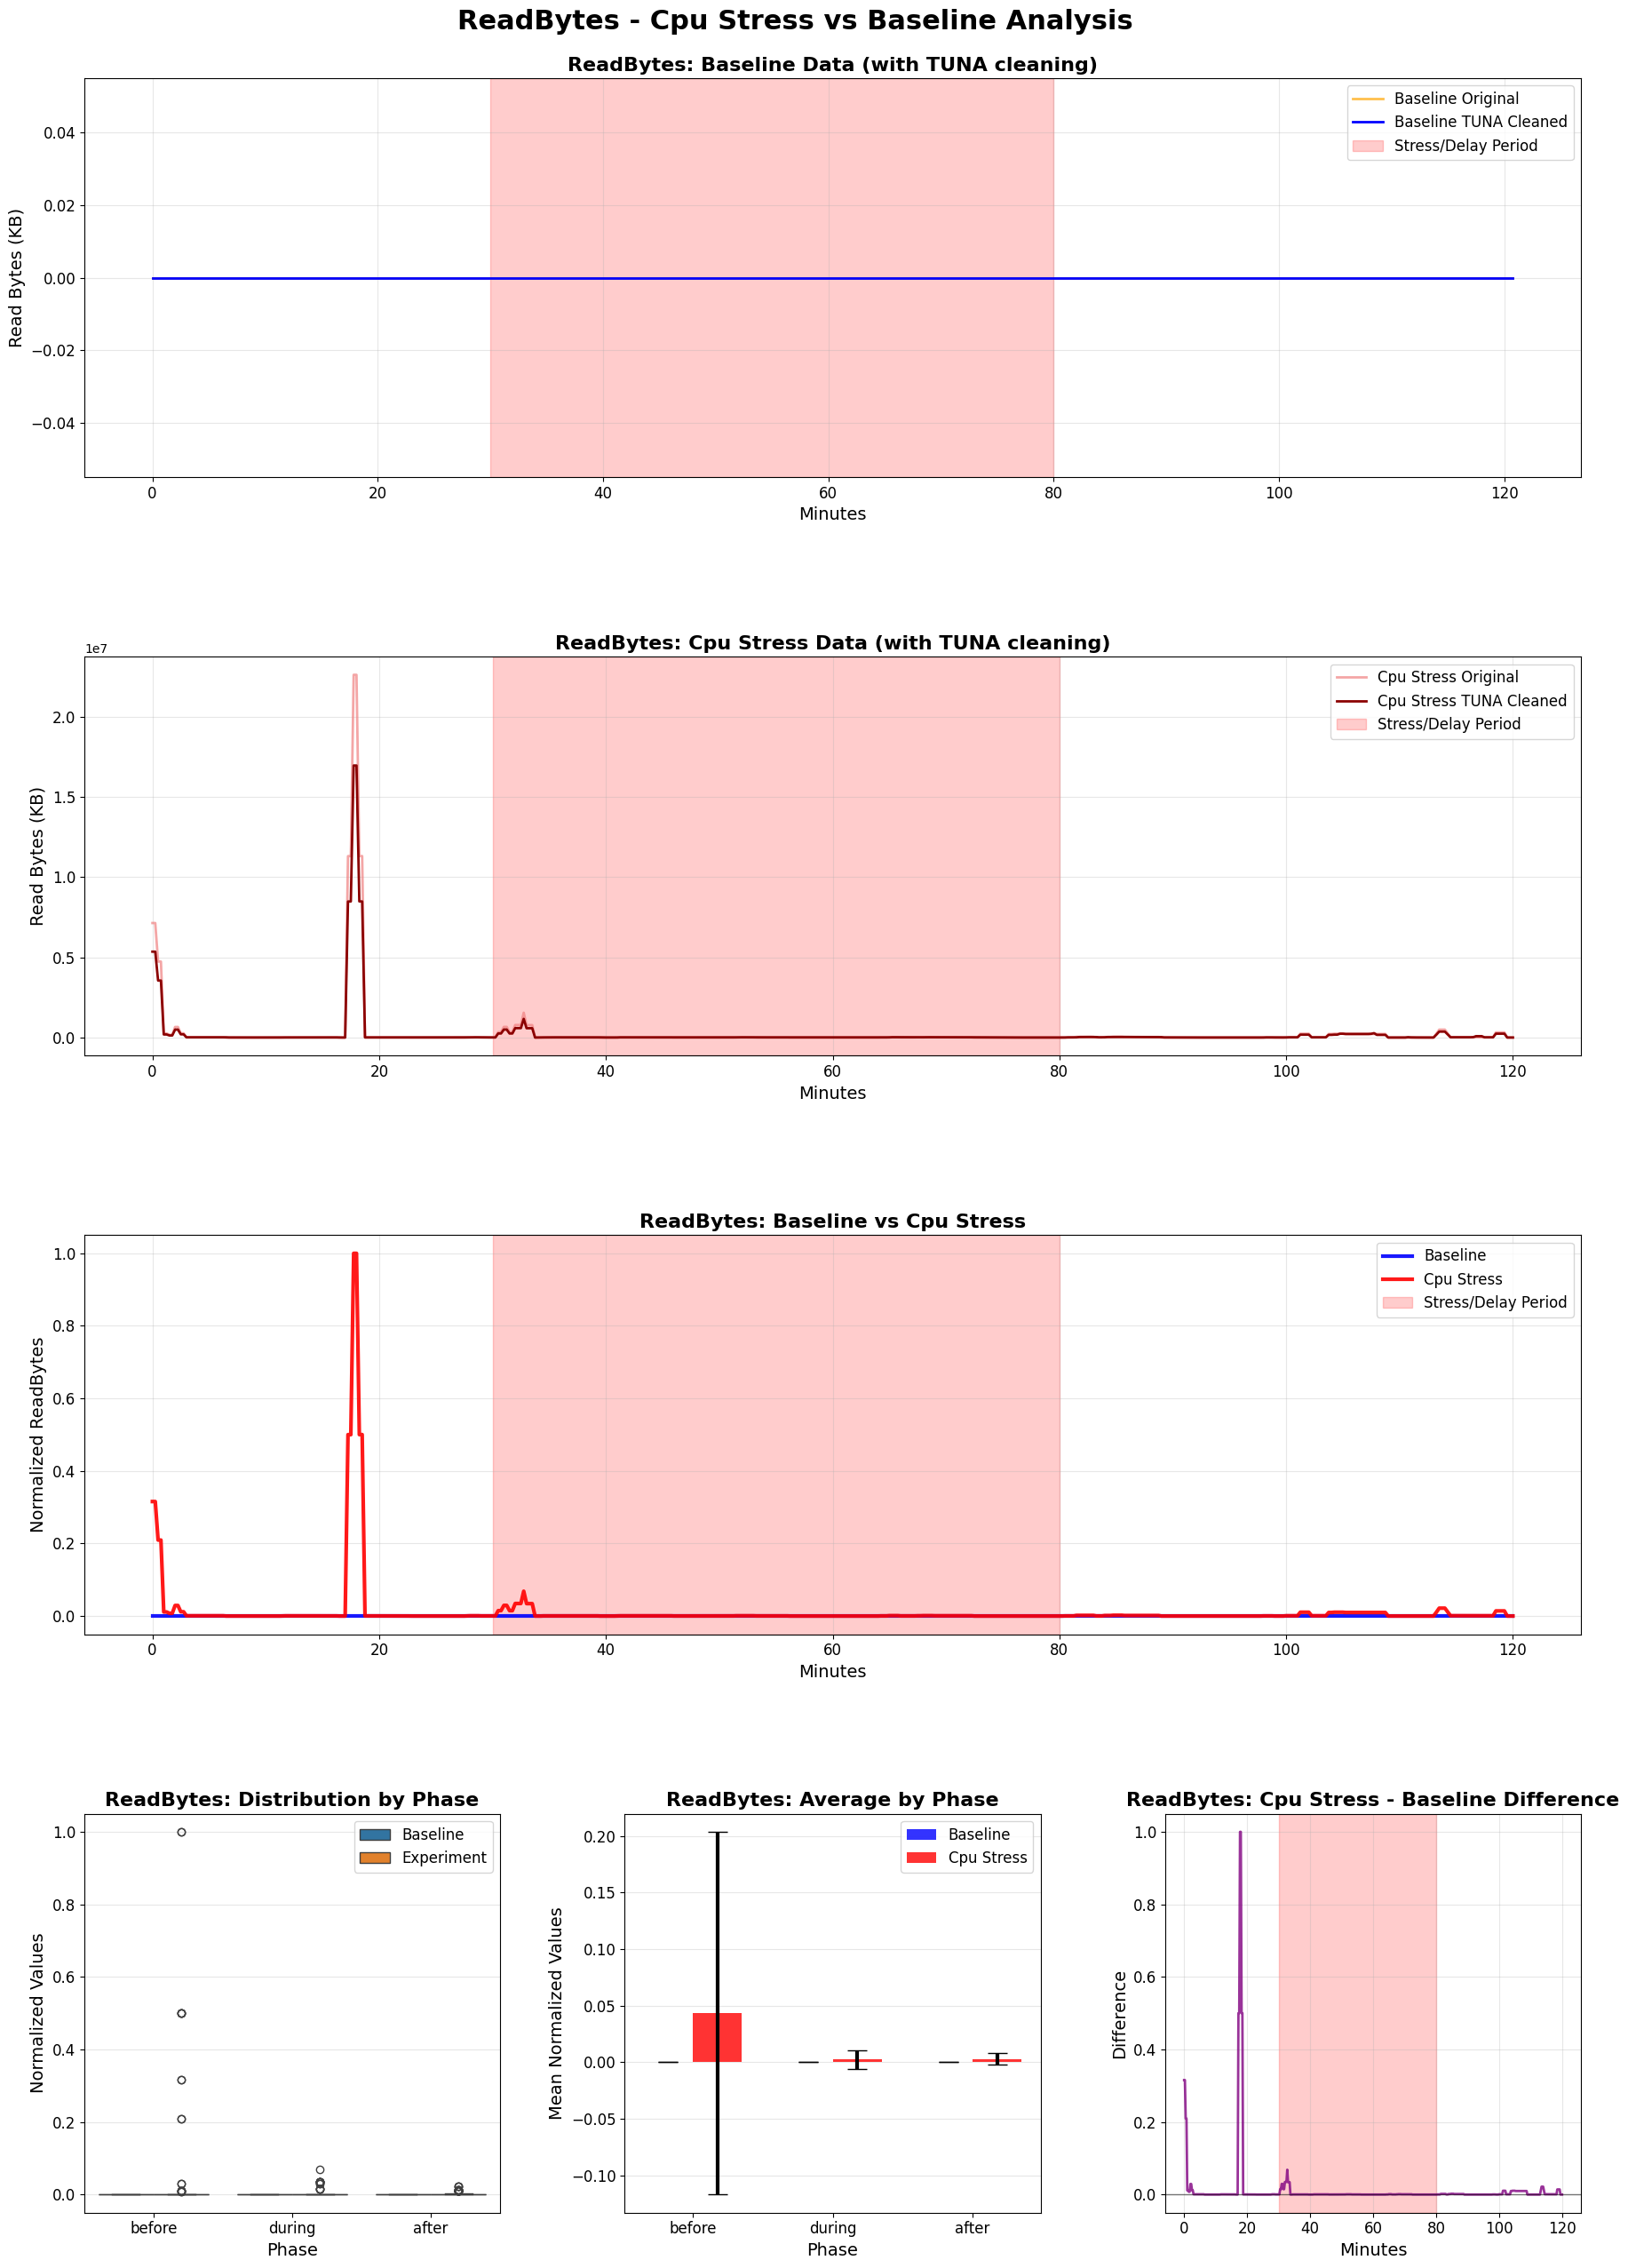


READBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 101 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: nan

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0029  0.0048  0.0  0.0217
before  0.0433  0.1605  0.0  1.0000
during  0.0022  0.0082  0.0  0.0684

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.96, p=  0.0034 (SIGNIFICANT)
  DURING  : t= -3.83, p=  0.0001 (SIGNIFICANT)
  AFTER   : t= -7.57, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed:

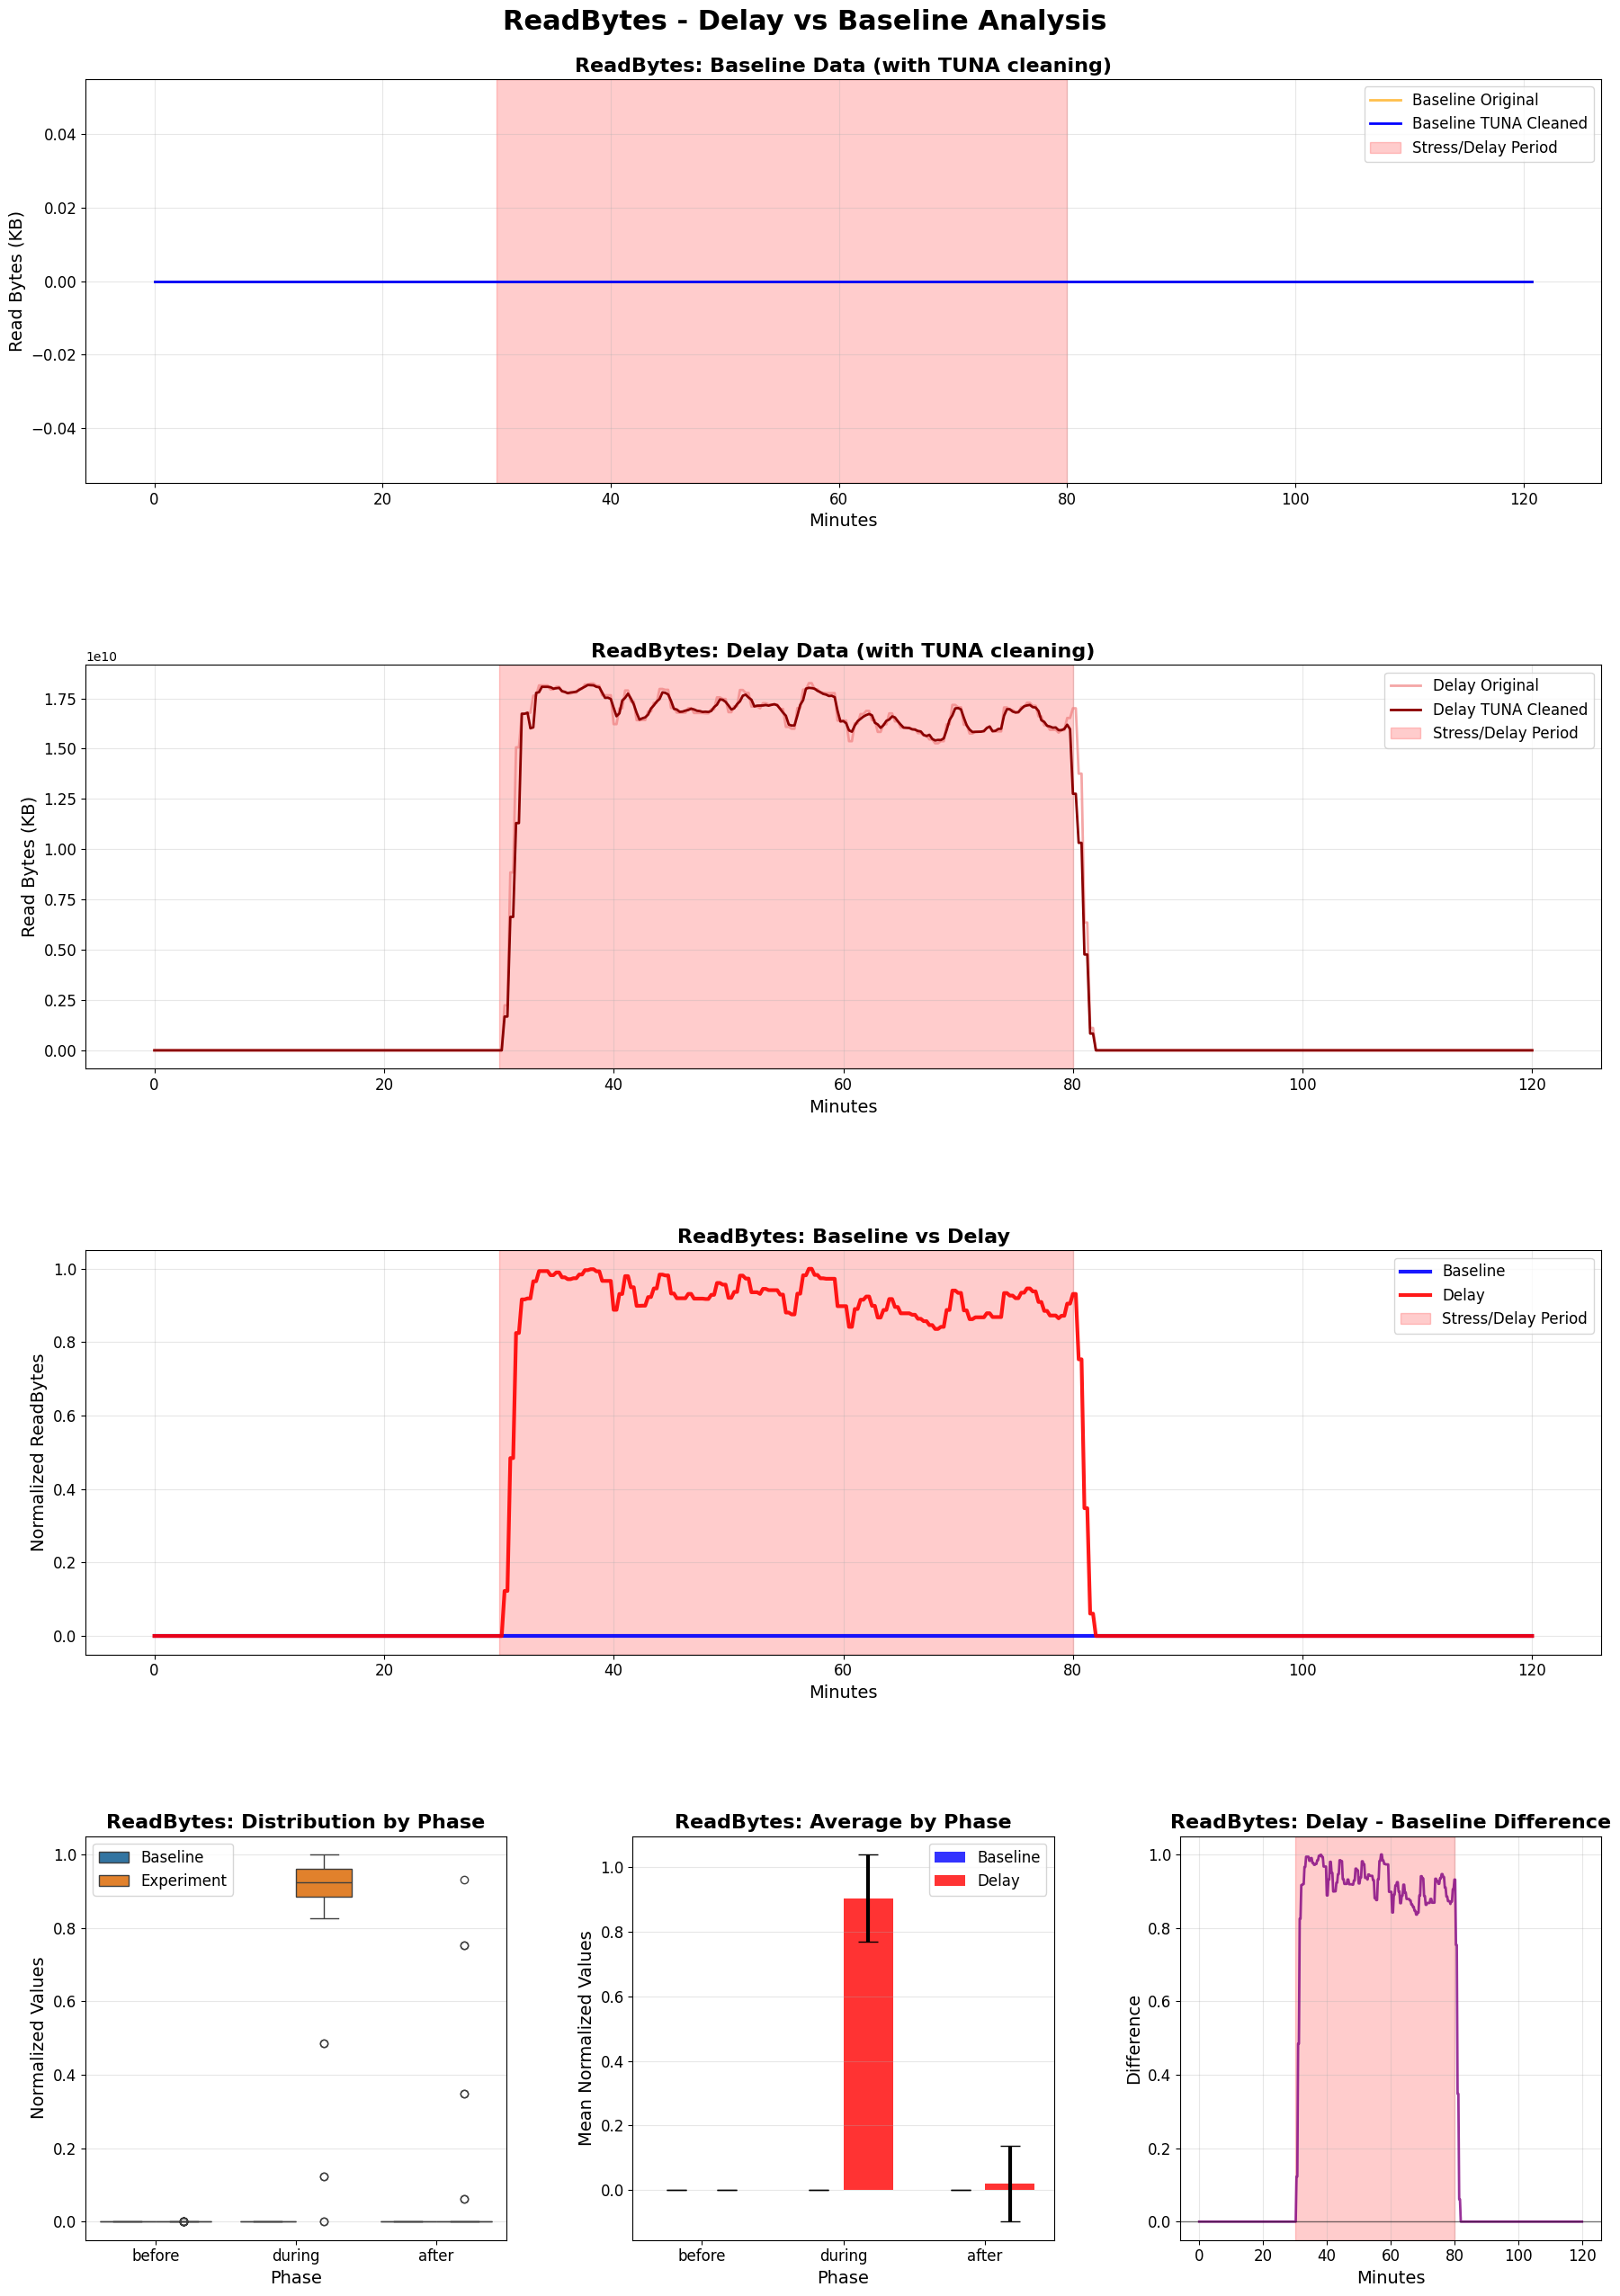


READBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 22 outliers removed
    Noise Reduction: 0.5%, Correlation: 0.998
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: nan

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

DELAY STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0204  0.1173  0.0  0.9316
before  0.0000  0.0000  0.0  0.0000
during  0.9024  0.1354  0.0  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.35, p=  0.0195 (SIGNIFICANT)
  DURING  : t=-94.50, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -2.20, p=  0.0289 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeuler-home', 'o

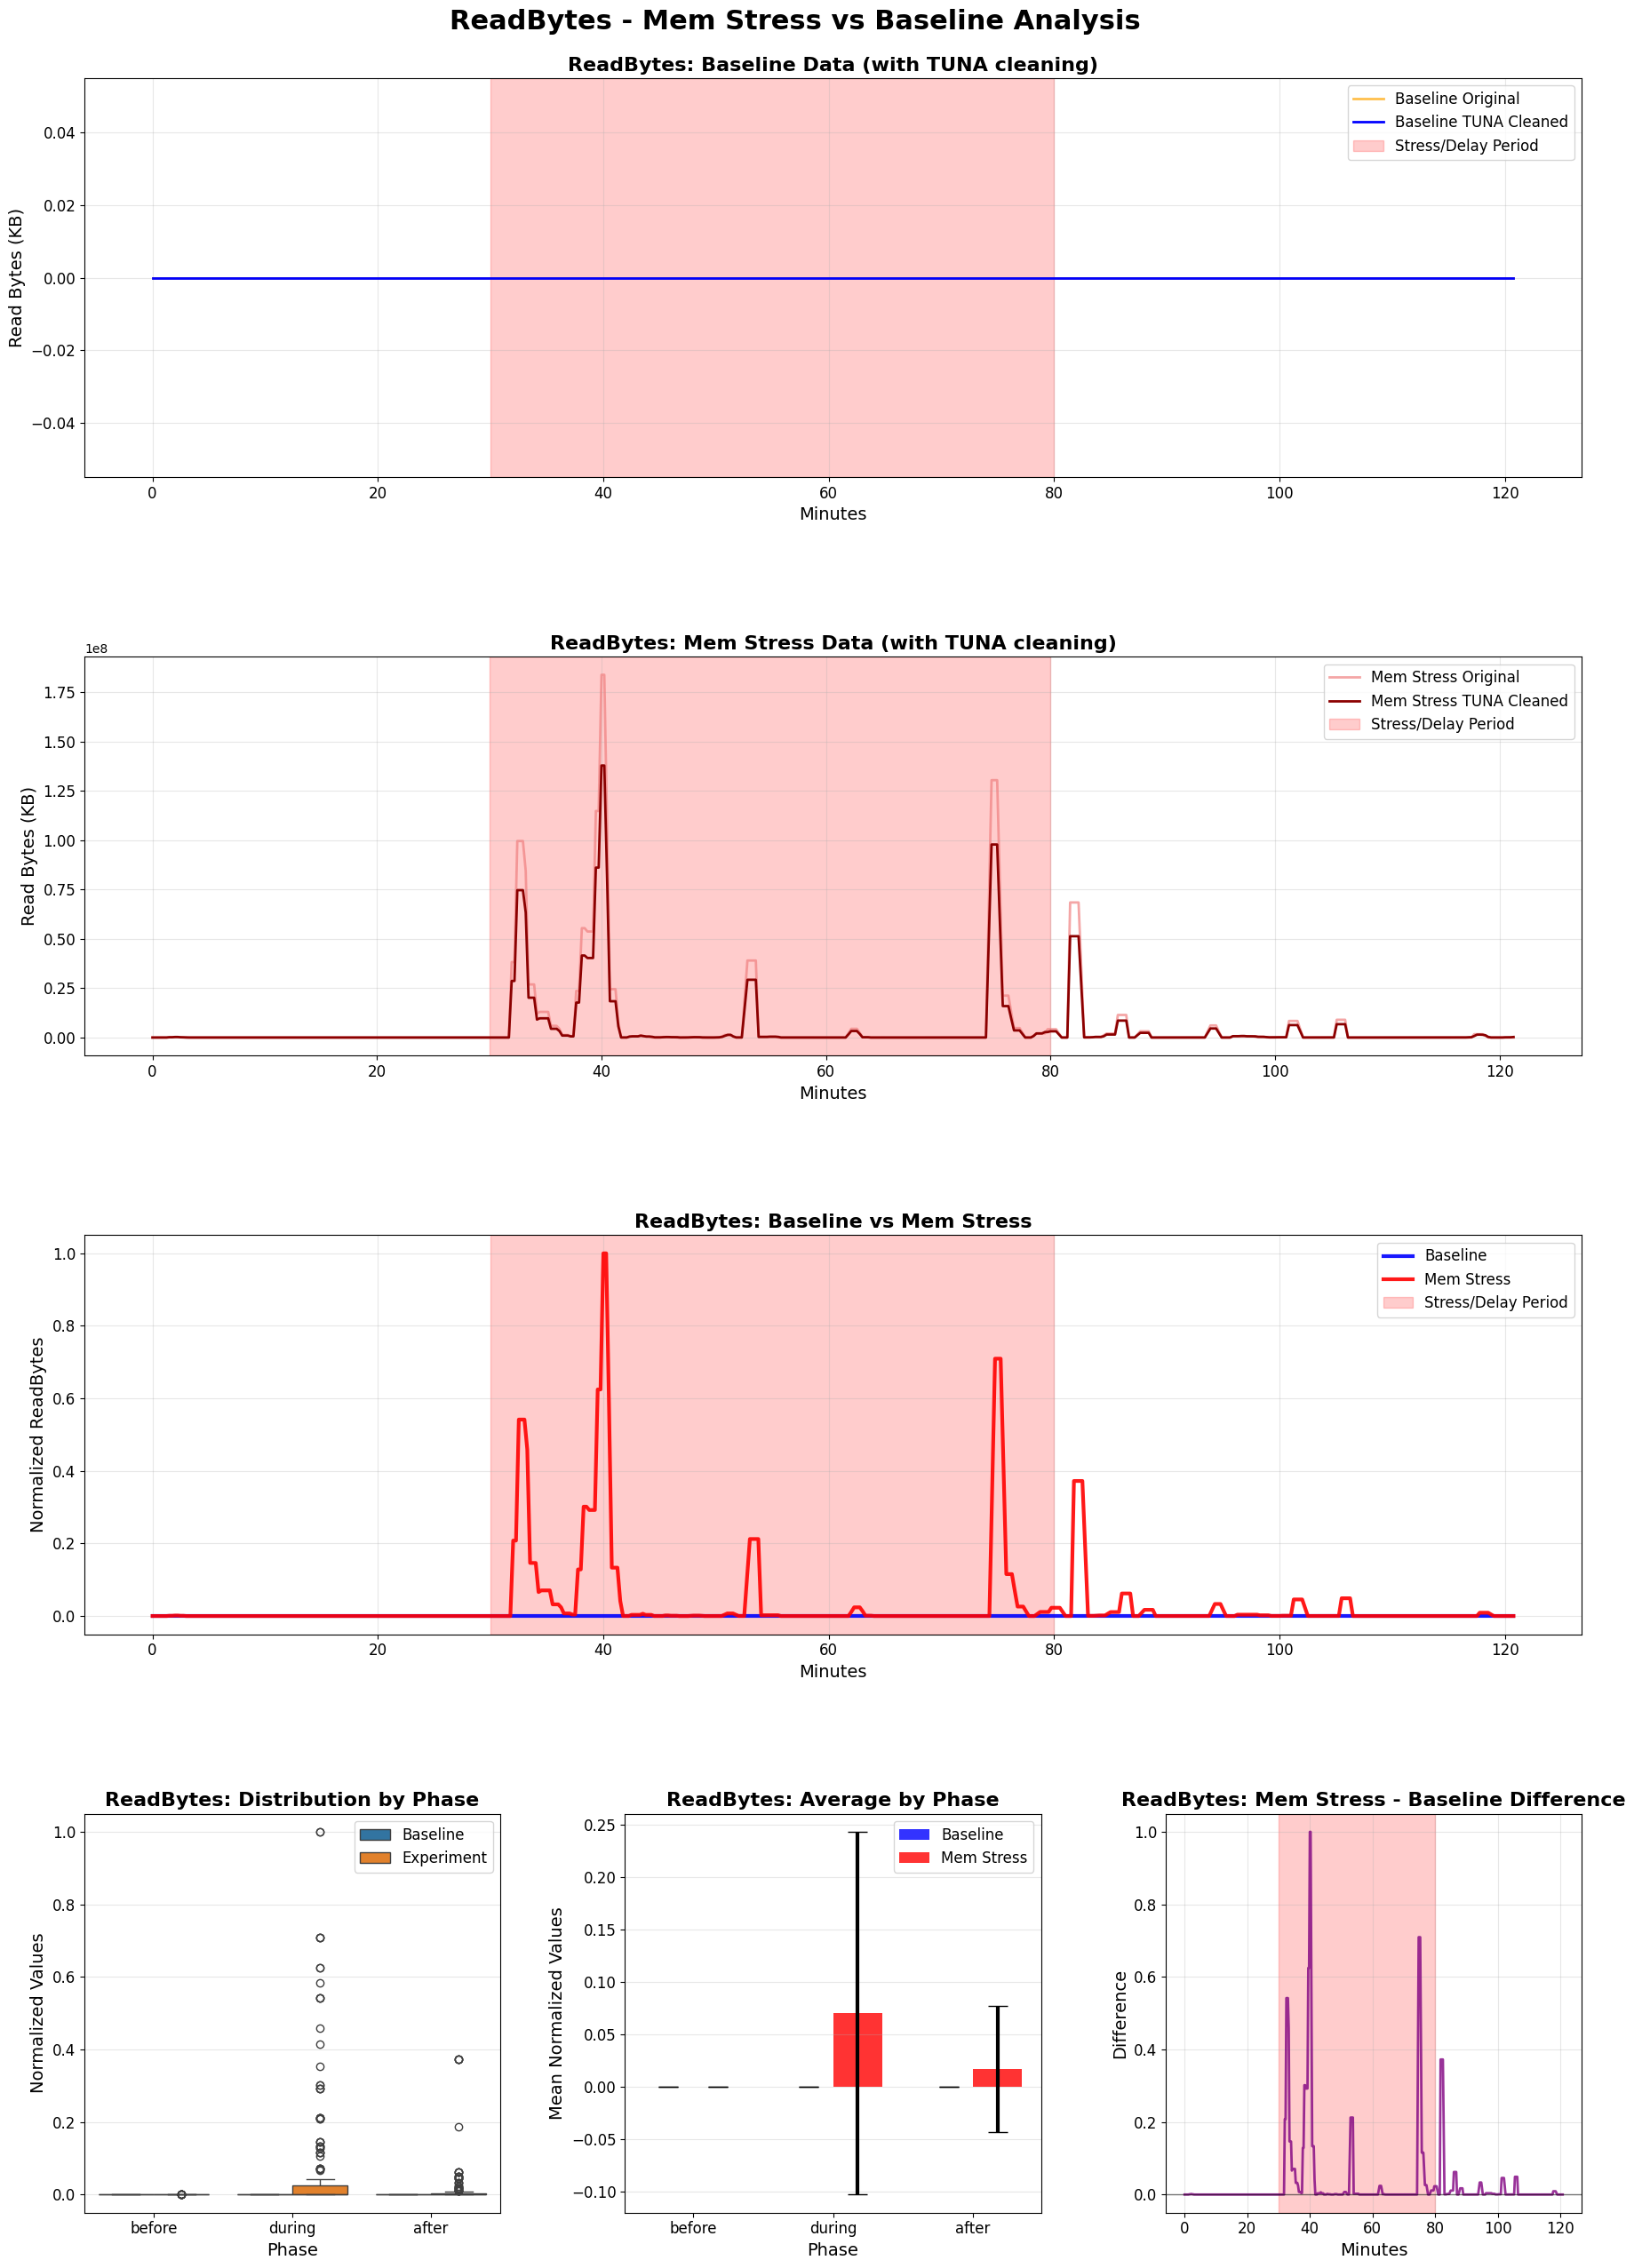


READBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 167 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: nan

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0168  0.0601  0.0  0.3724
before  0.0000  0.0002  0.0  0.0014
during  0.0701  0.1729  0.0  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.48, p=  0.0139 (SIGNIFICANT)
  DURING  : t= -5.75, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.58, p=  0.0004 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed:

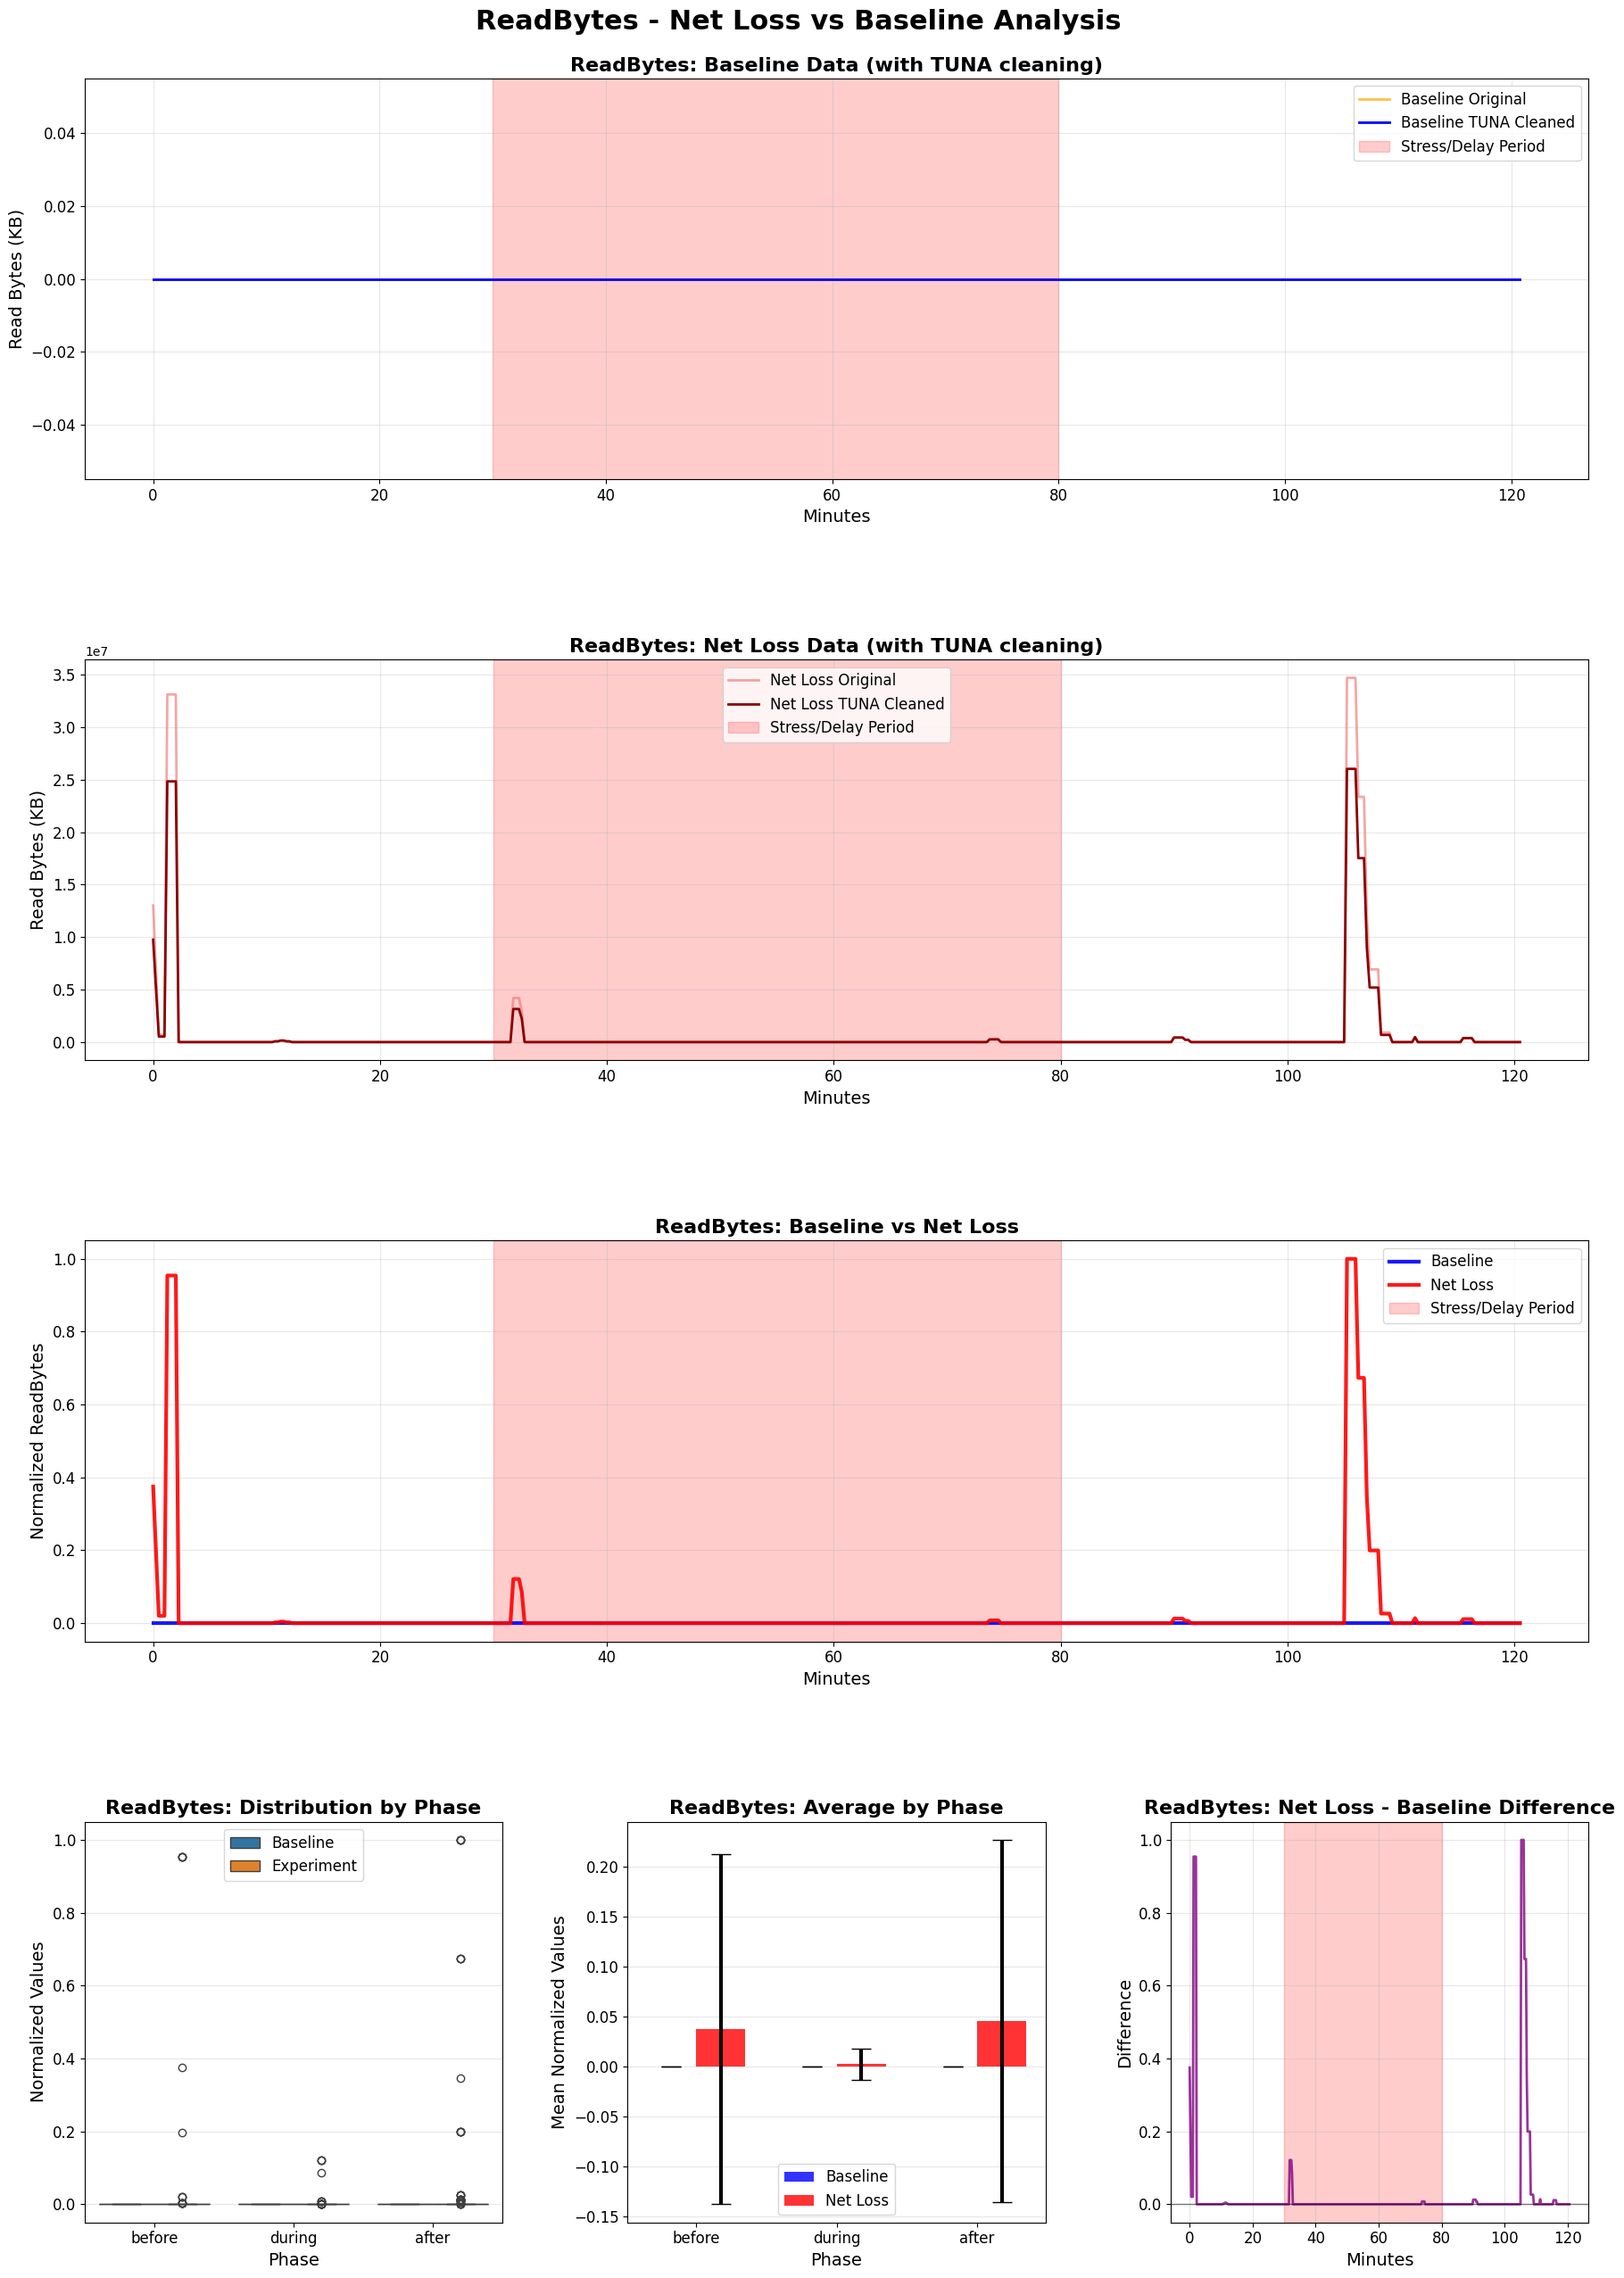


READBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 49 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: nan

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0456  0.1815  0.0  1.0000
before  0.0372  0.1753  0.0  0.9543
during  0.0024  0.0159  0.0  0.1211

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.33, p=  0.0208 (SIGNIFICANT)
  DURING  : t= -2.14, p=  0.0331 (SIGNIFICANT)
  AFTER   : t= -3.20, p=  0.0015 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeu

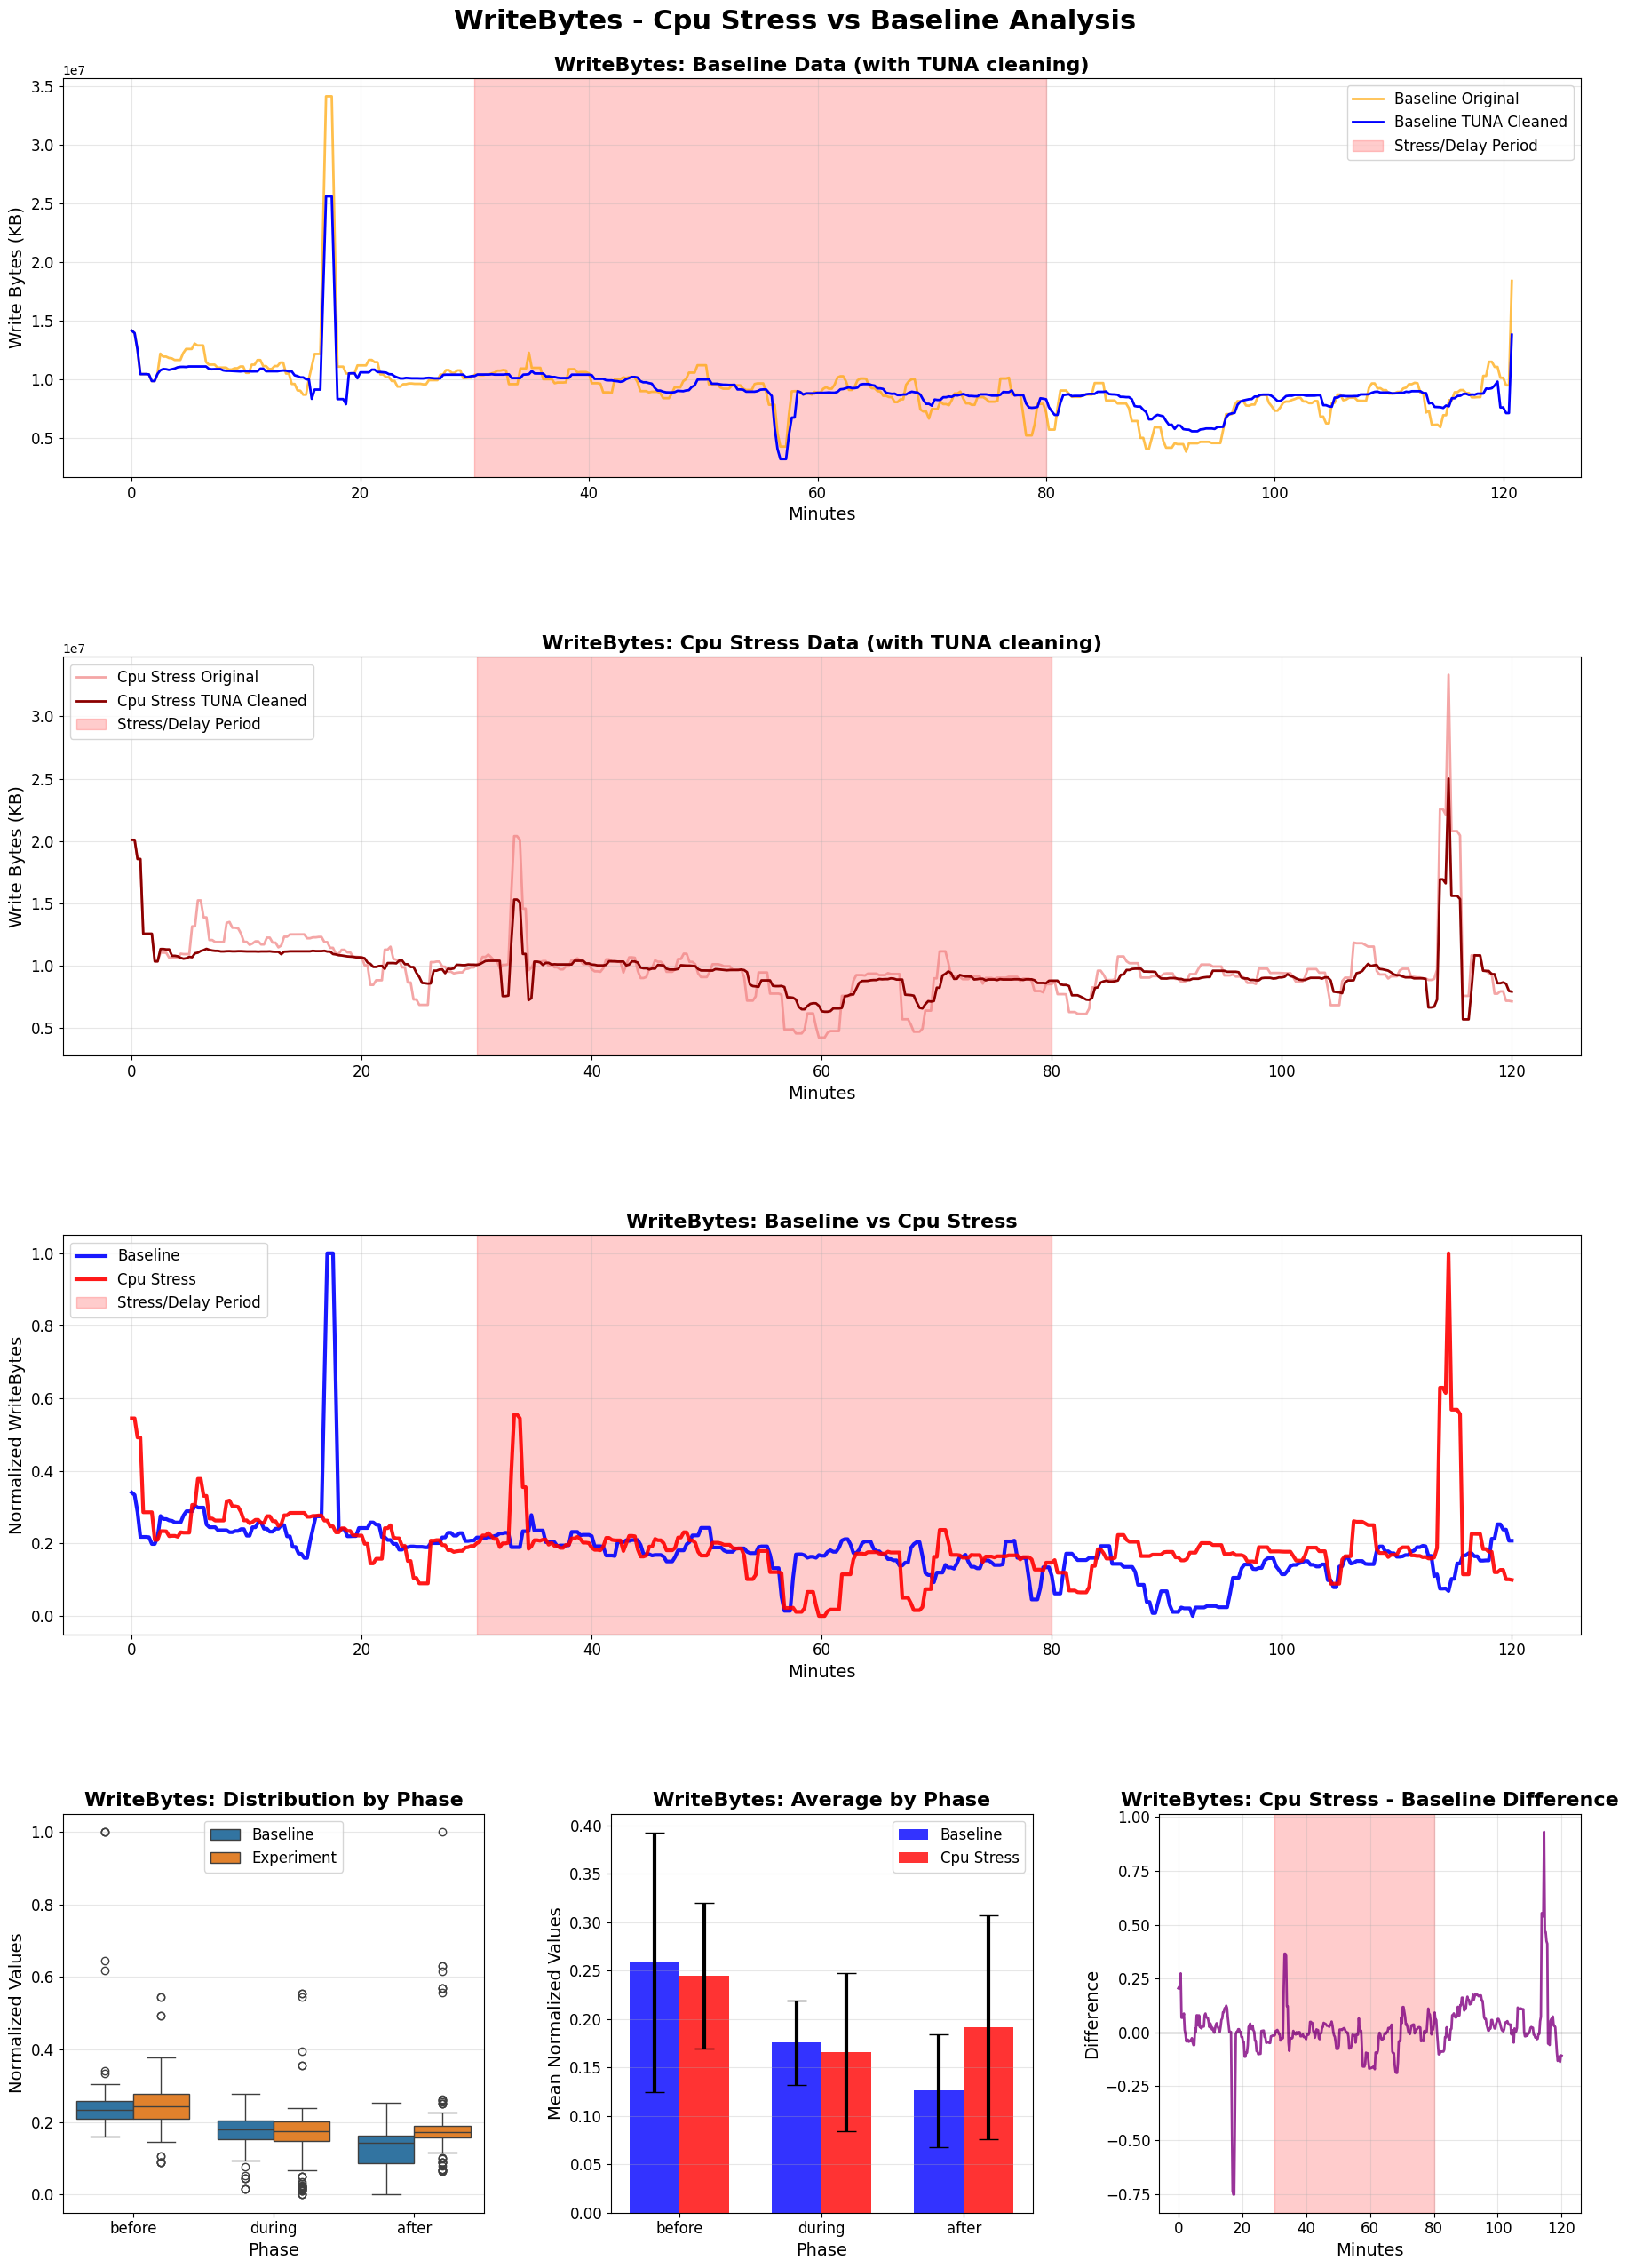


WRITEBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 27 outliers removed
    Noise Reduction: 33.3%, Correlation: 0.913
  BASELINE: 26 outliers removed
    Noise Reduction: 31.1%, Correlation: 0.940

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1260  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1911  0.1156  0.0652  1.0000
before  0.2448  0.0755  0.0901  0.5450
during  0.1657  0.0818  0.0000  0.5553

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  0.97, p=  0.3350 (NOT SIGNIFICANT)
  DURING  : t=  1.51, p=  0.1316 (NOT SIGNIFICANT)
  AFTER   : t= -6.36, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   -5.25% (DECREASE)
  DURING  :   -5.63% (DECREASE)
  AFTER   :  +51.65% (INCREASE)

DISK I/O METRICS 

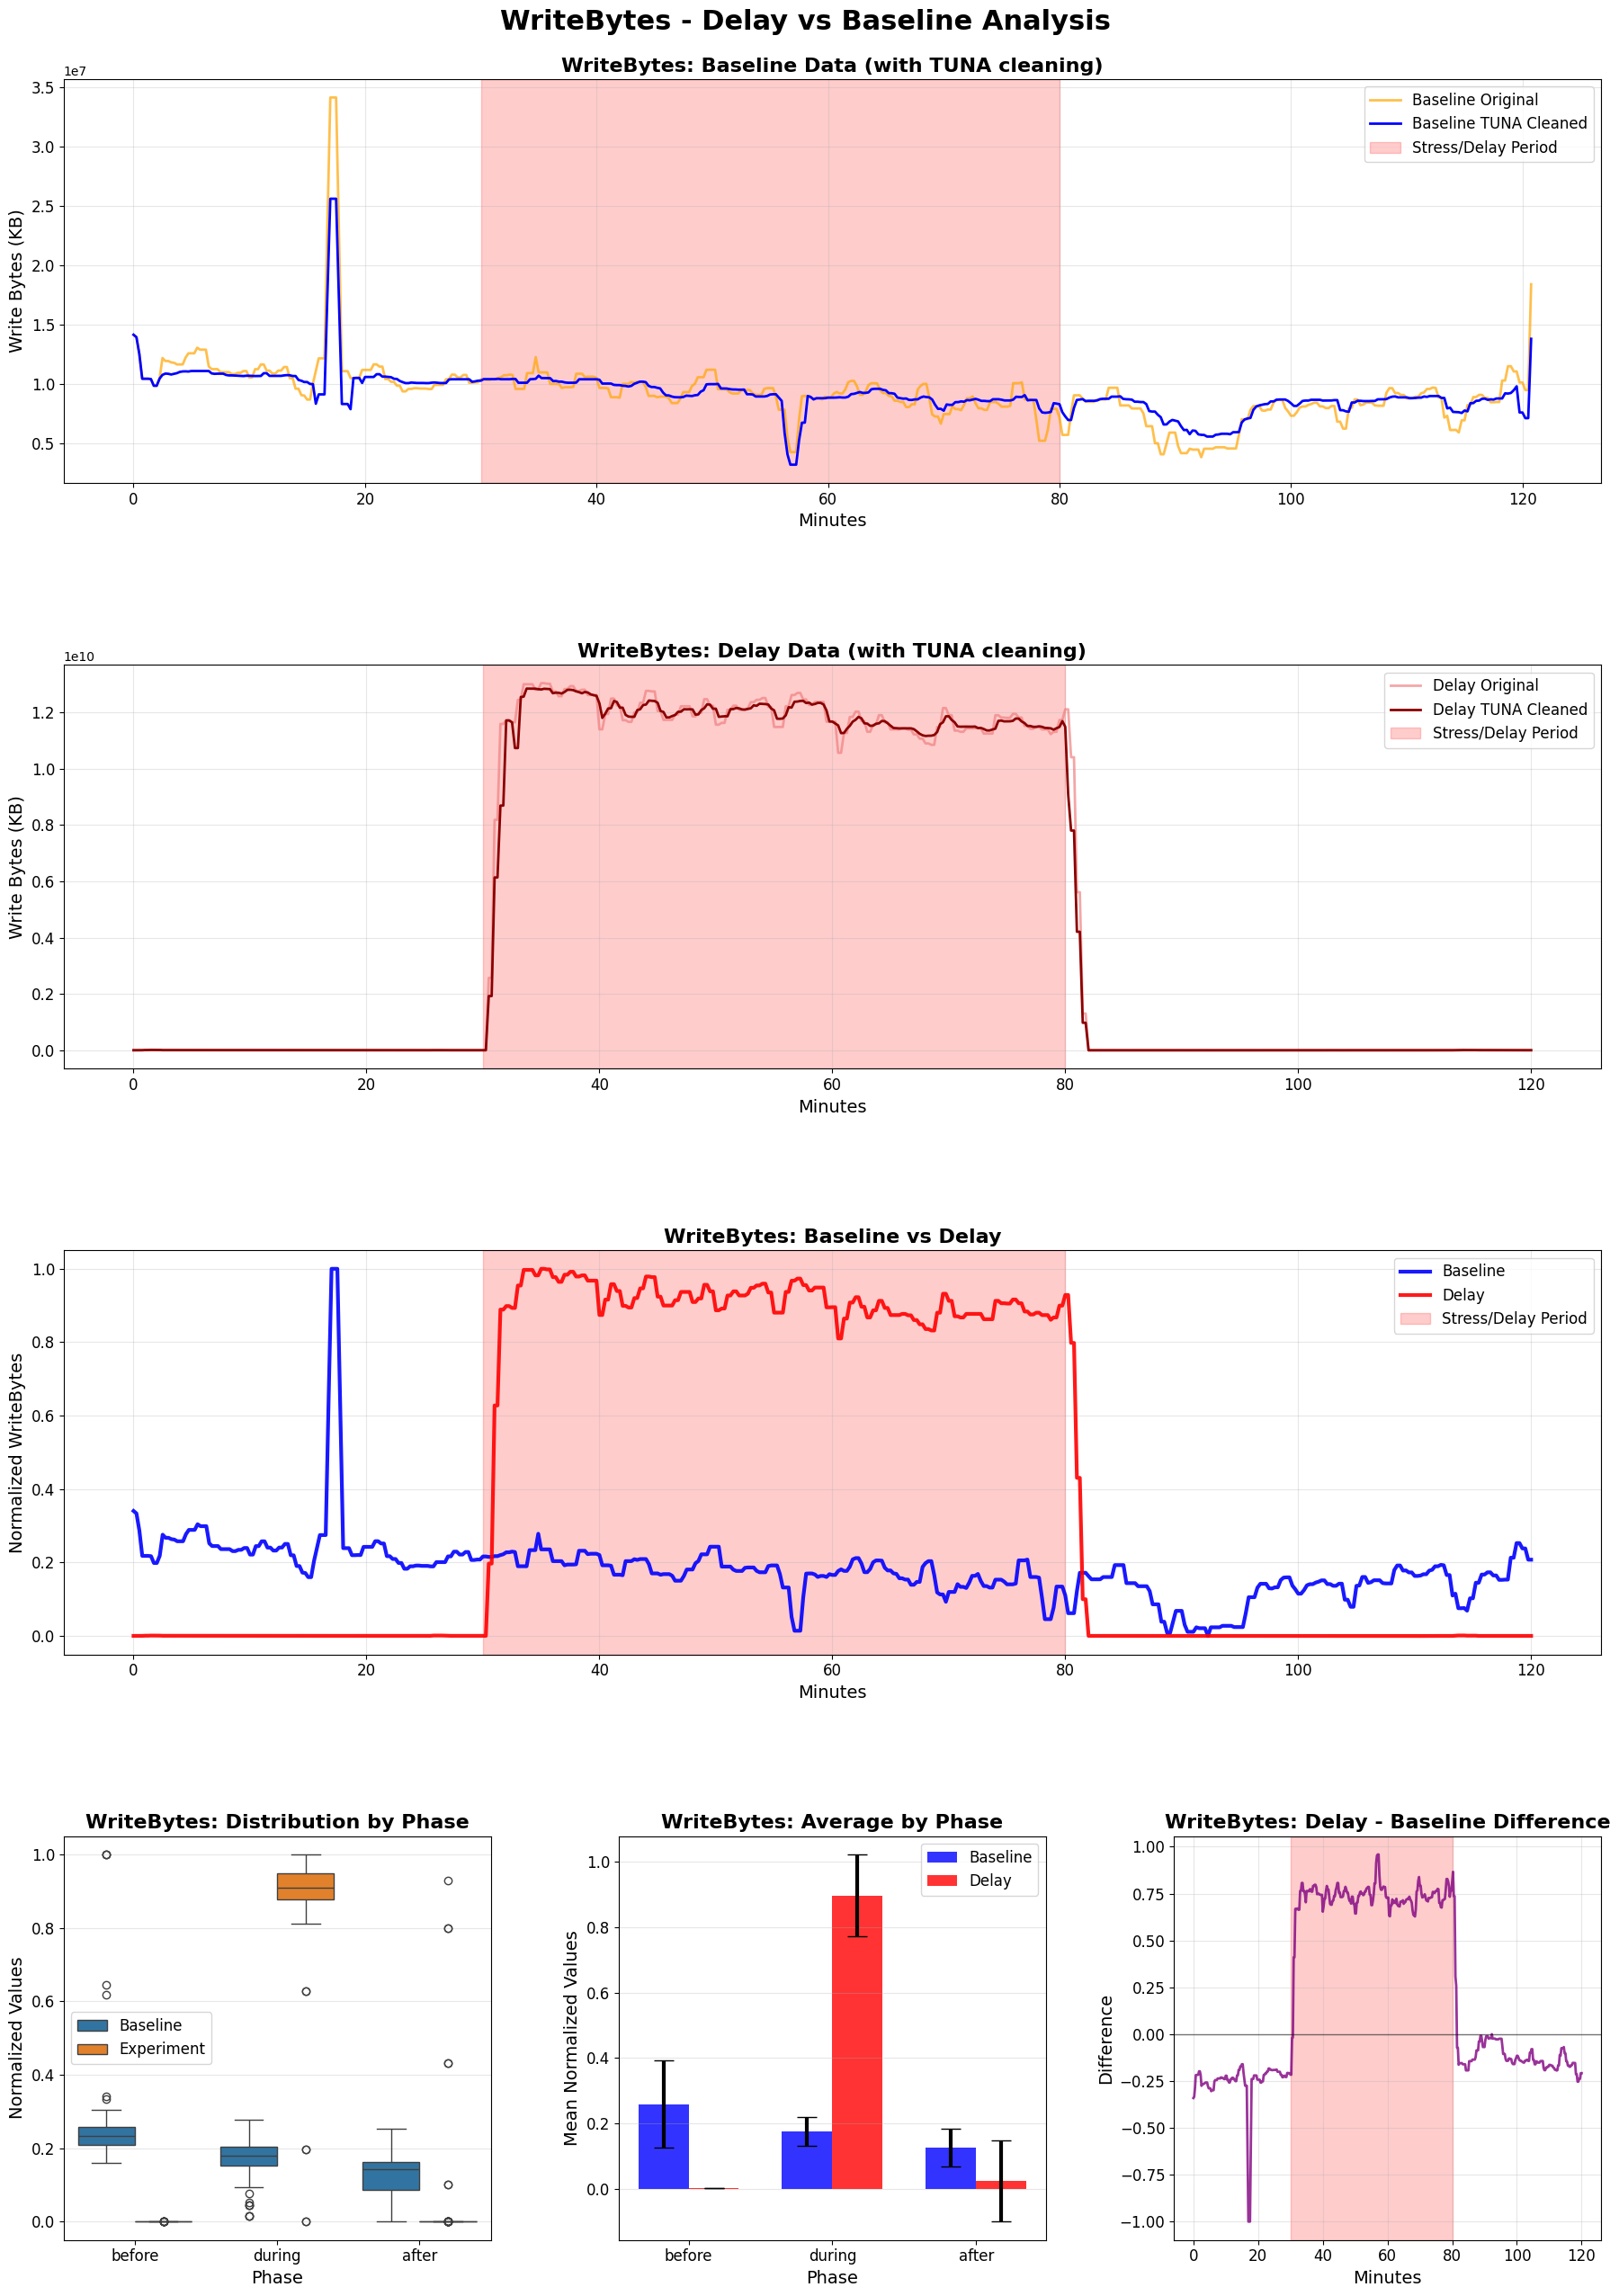


WRITEBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 21 outliers removed
    Noise Reduction: 0.6%, Correlation: 0.998
  BASELINE: 26 outliers removed
    Noise Reduction: 31.1%, Correlation: 0.940

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1260  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0227  0.1240  0.0000  0.9287
before  0.0005  0.0002  0.0003  0.0012
during  0.8968  0.1256  0.0004  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 21.06, p=  0.0000 (SIGNIFICANT)
  DURING  : t=-76.93, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  9.54, p=  0.0000 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :  -99.79% (DECREASE)
  DURING  : +410.73% (INCREASE)
  AFTER   :  -81.99% (DECREASE)

DISK I/O METRICS DETAILS:
  Metric: WriteBytes

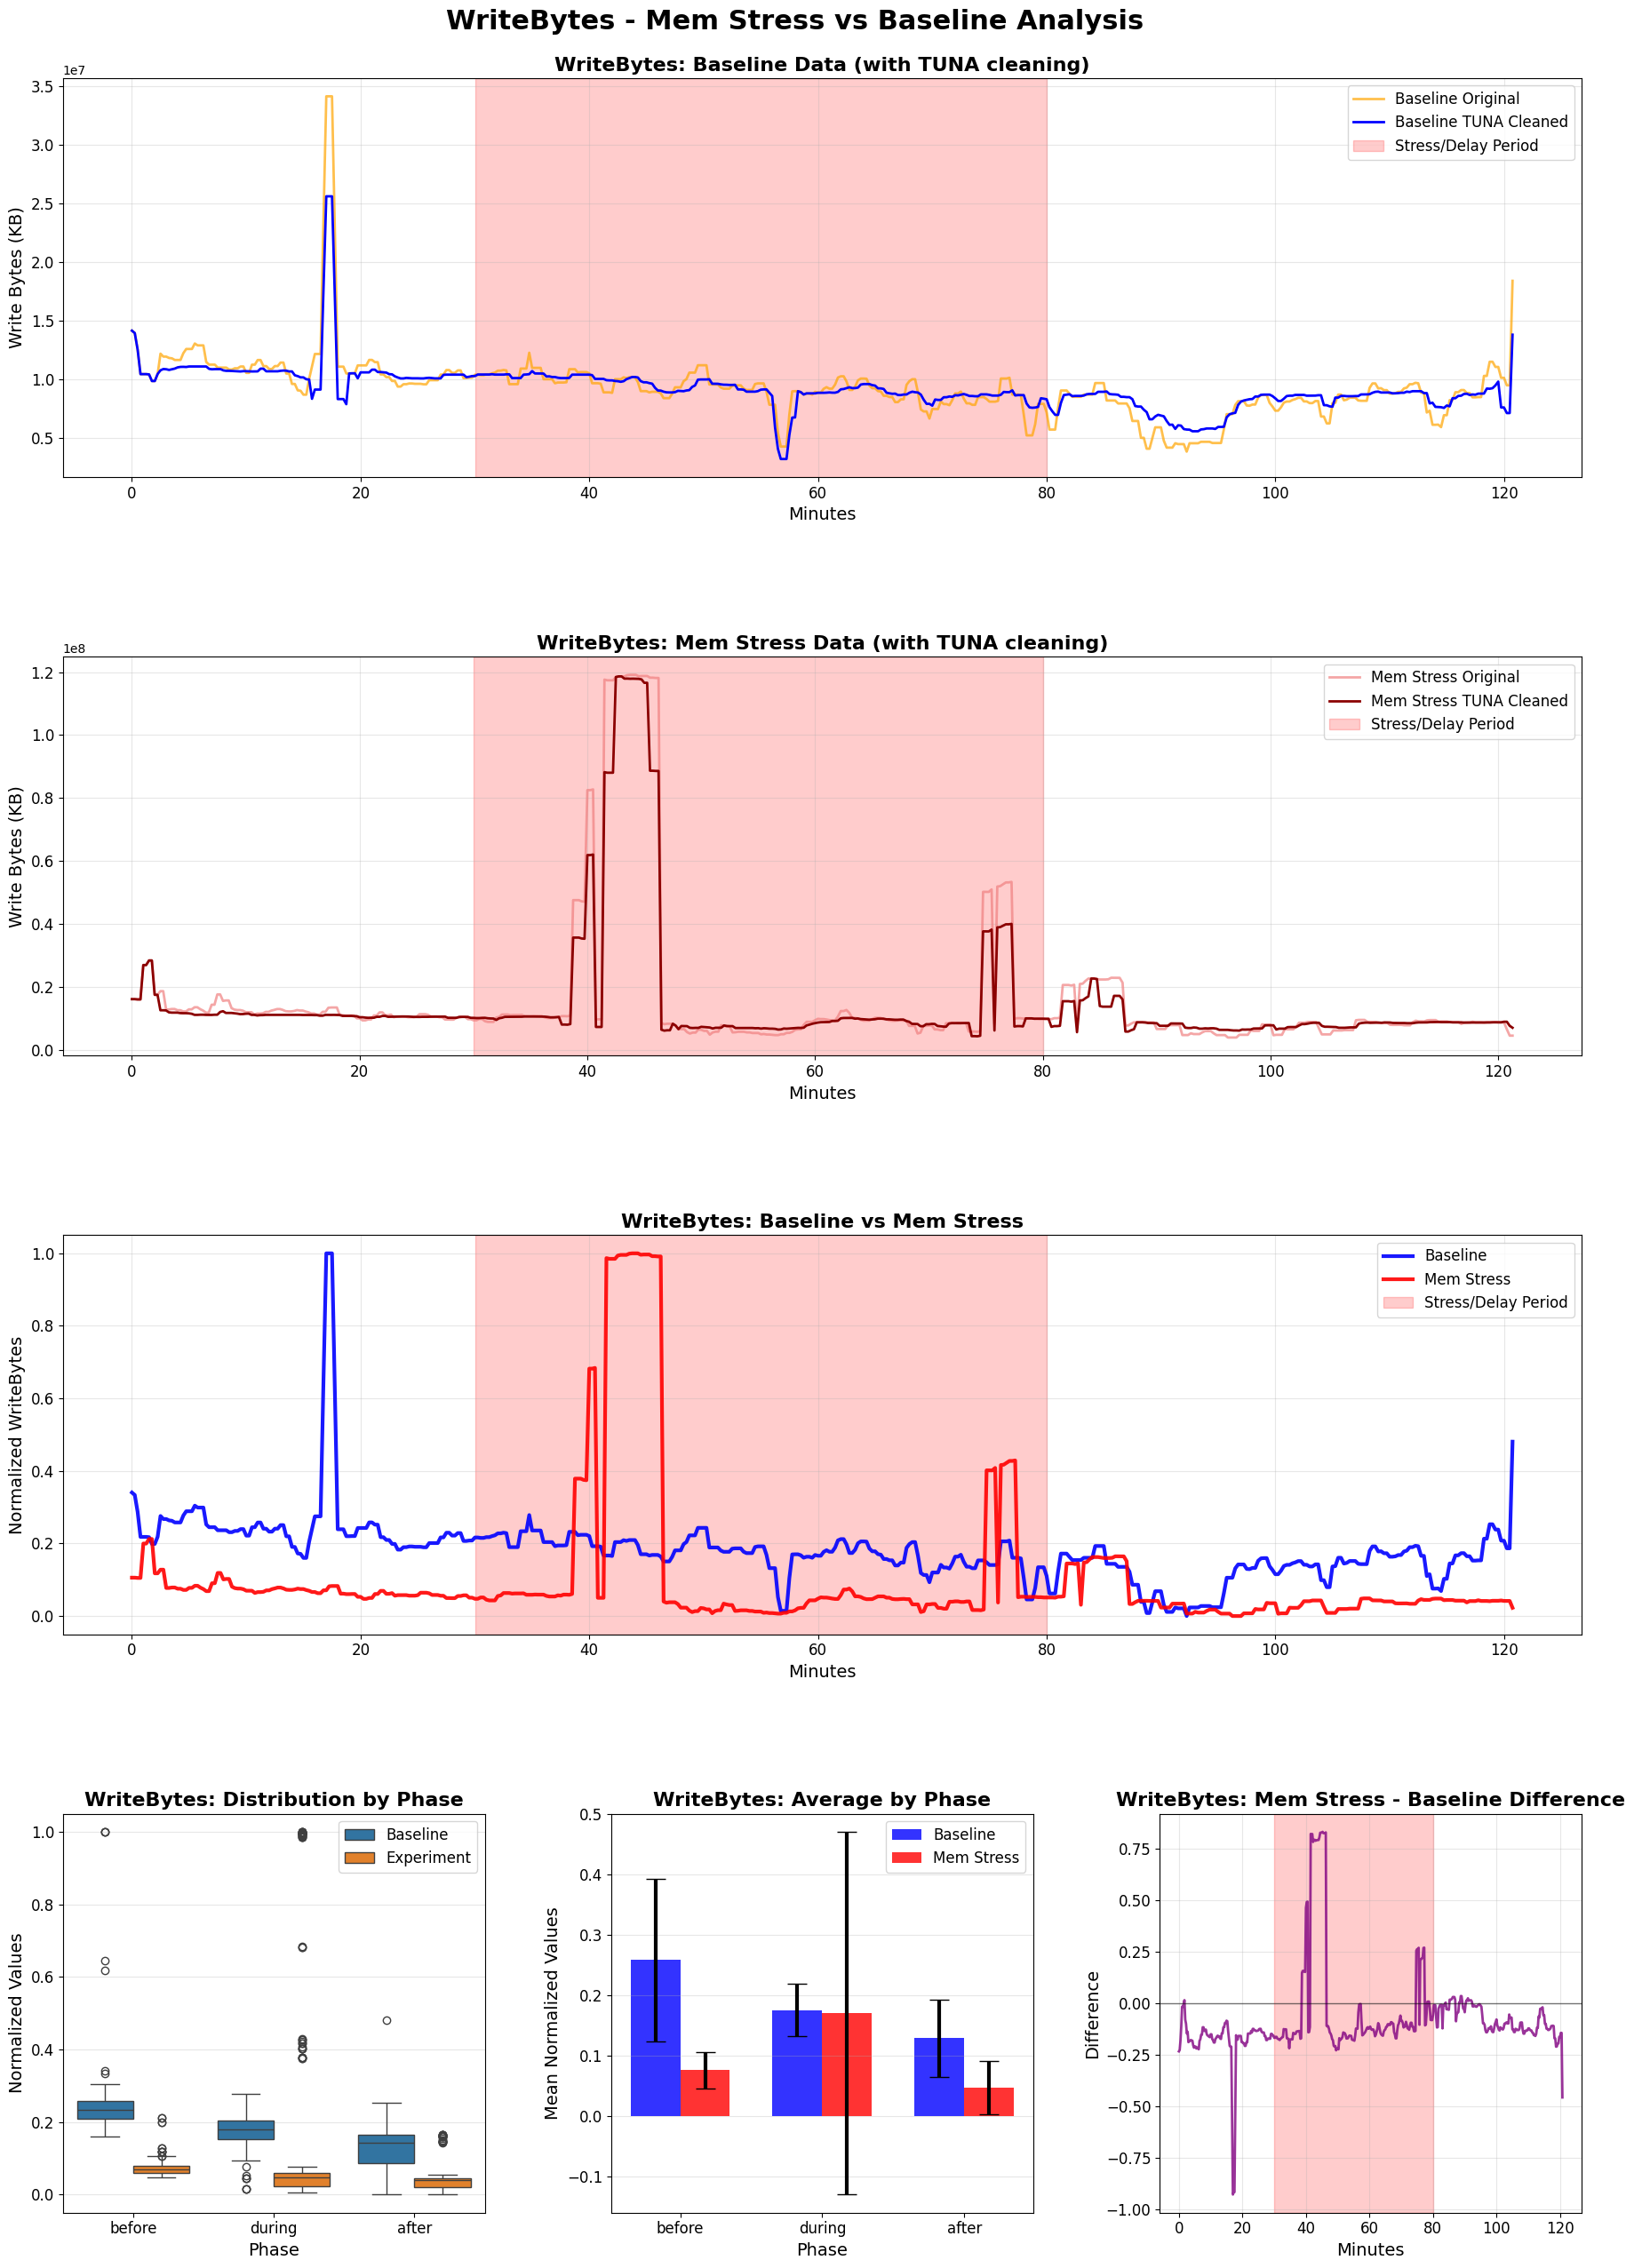


WRITEBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 68 outliers removed
    Noise Reduction: 12.8%, Correlation: 0.985
  BASELINE: 26 outliers removed
    Noise Reduction: 31.1%, Correlation: 0.940

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

MEM STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0469  0.0444  0.0000  0.1647
before  0.0761  0.0298  0.0473  0.2124
during  0.1704  0.3004  0.0066  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 14.53, p=  0.0000 (SIGNIFICANT)
  DURING  : t=  0.24, p=  0.8086 (NOT SIGNIFICANT)
  AFTER   : t= 13.40, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :  -70.53% (DECREASE)
  DURING  :   -2.95% (DECREASE)
  AFTER   :  -63.62% (DECREASE)

DISK I/O METRICS DETA

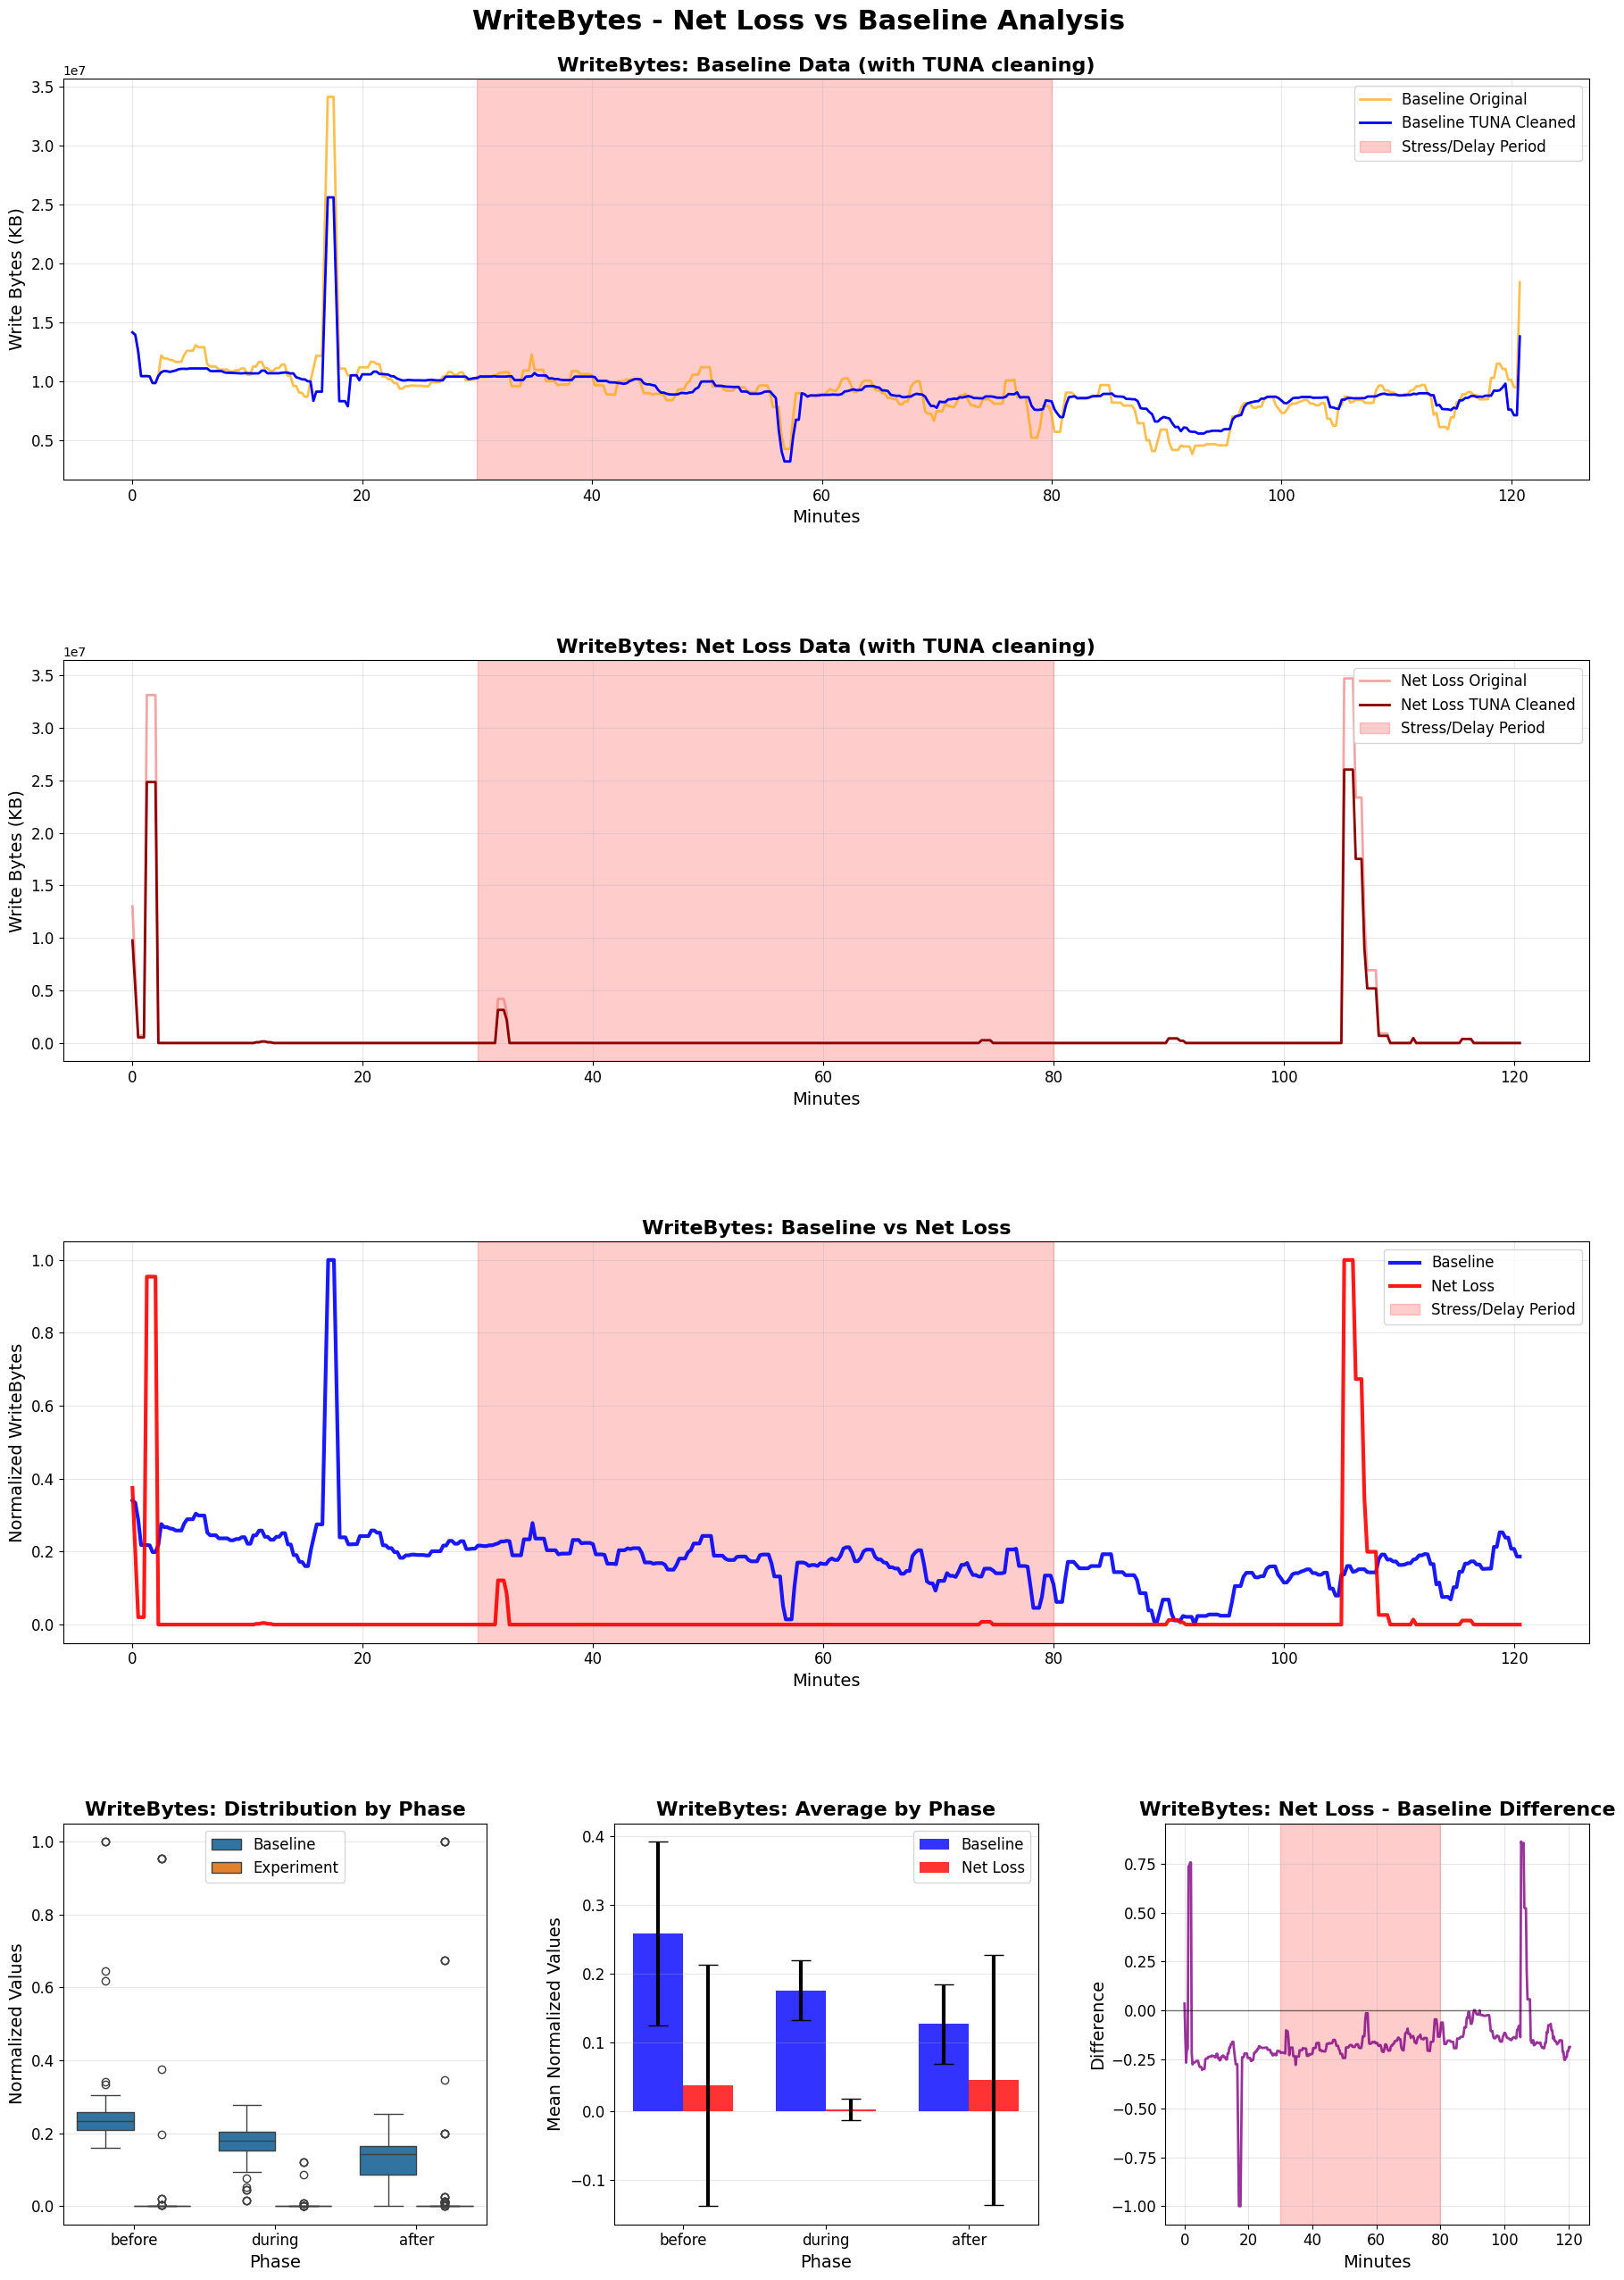


WRITEBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 49 outliers removed
    Noise Reduction: 25.0%, Correlation: 1.000
  BASELINE: 26 outliers removed
    Noise Reduction: 31.1%, Correlation: 0.940

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1268  0.0582  0.0000  0.2530
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

NET LOSS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0456  0.1815  0.0  1.0000
before  0.0372  0.1753  0.0  0.9543
during  0.0024  0.0159  0.0  0.1211

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 10.97, p=  0.0000 (SIGNIFICANT)
  DURING  : t= 53.02, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  5.42, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :  -85.59% (DECREASE)
  DURING  :  -98.64% (DECREASE)
  AFTER   :  -64.01% (DECREASE)

DISK I/O METRICS DETAILS:
  Metric: WriteBytes
 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

def calculate_disk_values(df, metric_name):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'BlockLatency':
        return df[value_cols[0]].values
    else:
        return df[value_cols].sum(axis=1).values

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series(np.zeros(len(series)), index=series.index)

def get_y_axis_label(metric_name):
    labels = {
        'BlockLatency': 'Block Latency (ms)',
        'ReadBytes': 'Read Bytes (KB)',
        'WriteBytes': 'Write Bytes (KB)',
        'DiskUtil': 'Disk Utilization (%)',
        'IOPS': 'I/O Operations per Second',
        'ThroughputRead': 'Read Throughput (MB/s)',
        'ThroughputWrite': 'Write Throughput (MB/s)'
    }
    return labels.get(metric_name, 'Disk I/O Value')

def analyze_and_plot_disk_comparison(metric_name, experiment_name, experiment_df, baseline_df, 
                                   tuna_results=None, delay_minutes=30, duration_minutes=50):
    
    experiment_values = calculate_disk_values(experiment_df, metric_name)
    baseline_values = calculate_disk_values(baseline_df, metric_name)
    
    experiment_series = pd.Series(experiment_values, index=experiment_df.index)
    baseline_series = pd.Series(baseline_values, index=baseline_df.index)
    
    experiment_cleaned = None
    baseline_cleaned = None
    if tuna_results and metric_name in tuna_results:
        if experiment_name in tuna_results[metric_name]:
            experiment_cleaned = pd.Series(tuna_results[metric_name][experiment_name]['cleaned'])
        if 'baseline' in tuna_results[metric_name]:
            baseline_cleaned = pd.Series(tuna_results[metric_name]['baseline']['cleaned'])
    
    experiment_norm = normalize_series(experiment_series)
    baseline_norm = normalize_series(baseline_series)
    
    min_length = min(len(experiment_norm), len(baseline_norm), len(experiment_df['Minutes']), len(baseline_df['Minutes']))
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm.iloc[:min_length],
        'Experiment': experiment_norm.iloc[:min_length],
        'Minutes': experiment_df['Minutes'].iloc[:min_length],
        'Baseline_Minutes': baseline_df['Minutes'].iloc[:min_length]
    })
    
    df_combined['difference'] = df_combined['Experiment'] - df_combined['Baseline']
    
    df_combined['phase'] = 'before'
    df_combined.loc[(df_combined['Minutes'] >= delay_minutes) & 
                   (df_combined['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df_combined.loc[df_combined['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    
    stats_baseline = df_combined.groupby('phase')['Baseline'].agg(['mean', 'std', 'min', 'max'])
    stats_experiment = df_combined.groupby('phase')['Experiment'].agg(['mean', 'std', 'min', 'max'])
    
    t_tests = {}
    available_phases = stats_baseline.index.tolist()
    
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            data = df_combined[df_combined['phase'] == phase]
            if len(data) > 1:
                t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['Experiment'].dropna())
                t_tests[phase] = {'t': t_stat, 'p': p_value}
            else:
                t_tests[phase] = {'t': 0, 'p': 1}
        else:
            t_tests[phase] = {'t': 0, 'p': 1, 'note': 'Phase not present in data'}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            baseline_mean = stats_baseline.loc[phase, 'mean']
            experiment_mean = stats_experiment.loc[phase, 'mean']
            if baseline_mean != 0:
                impact[phase] = ((experiment_mean - baseline_mean) / baseline_mean) * 100
            else:
                impact[phase] = 0
        else:
            impact[phase] = 0
    
    fig = plt.figure(figsize=(18, 26))
    
    y_label = get_y_axis_label(metric_name)
    
    plt.subplot(4, 1, 1)
    plt.plot(baseline_df['Minutes'], baseline_series, 
             label='Baseline Original', color='orange', alpha=0.7, linewidth=2)
    
    if baseline_cleaned is not None:
        plt.plot(baseline_df['Minutes'].iloc[:len(baseline_cleaned)], baseline_cleaned, 
                 label='Baseline TUNA Cleaned', linewidth=2, color='blue')
        title_suffix = " (with TUNA cleaning)"
    else:
        plt.plot(baseline_df['Minutes'], baseline_series, 
                 label='Baseline', linewidth=2, color='blue')
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: Baseline Data{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 2)
    plt.plot(experiment_df['Minutes'], experiment_series, 
             label=f'{experiment_name.replace("_", " ").title()} Original', 
             alpha=0.7, color='lightcoral', linewidth=2)
    
    if experiment_cleaned is not None:
        plt.plot(experiment_df['Minutes'].iloc[:len(experiment_cleaned)], experiment_cleaned, 
                 label=f'{experiment_name.replace("_", " ").title()} TUNA Cleaned', 
                 linewidth=2, color='darkred')
        title_suffix = " (with TUNA cleaning)"
    else:
        plt.plot(experiment_df['Minutes'], experiment_series, 
                 label=f'{experiment_name.replace("_", " ").title()}', 
                 linewidth=2, color='darkred')
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} Data{title_suffix}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 3)
    plt.plot(df_combined['Minutes'], df_combined['Baseline'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(df_combined['Minutes'], df_combined['Experiment'], 
             label=f'{experiment_name.replace("_", " ").title()}', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f"{metric_name}: Baseline vs {experiment_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Minutes", fontsize=14)
    plt.ylabel(f"Normalized {metric_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 10)
    box_data = pd.melt(df_combined[['Baseline', 'Experiment', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{metric_name}: Distribution by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 11)
    phases_to_plot = [p for p in ['before', 'during', 'after'] if p in available_phases]
    
    if len(phases_to_plot) > 0:
        x = np.arange(len(phases_to_plot))
        width = 0.35
        
        baseline_means = [stats_baseline.loc[p, 'mean'] for p in phases_to_plot]
        baseline_stds = [stats_baseline.loc[p, 'std'] for p in phases_to_plot]
        experiment_means = [stats_experiment.loc[p, 'mean'] for p in phases_to_plot]
        experiment_stds = [stats_experiment.loc[p, 'std'] for p in phases_to_plot]
        
        bars1 = plt.bar(x - width/2, baseline_means, width, 
                       label='Baseline', alpha=0.8, color='blue')
        bars2 = plt.bar(x + width/2, experiment_means, width, 
                       label=f'{experiment_name.replace("_", " ").title()}', alpha=0.8, color='red')
        
        plt.errorbar(x - width/2, baseline_means, yerr=baseline_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        plt.errorbar(x + width/2, experiment_means, yerr=experiment_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        
        plt.xticks(x, phases_to_plot)
    else:
        plt.text(0.5, 0.5, 'No phase data available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
    
    plt.title(f'{metric_name}: Average by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Mean Normalized Values', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 12)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} - Baseline Difference', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel('Difference', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} - {experiment_name.replace("_", " ").title()} vs Baseline Analysis', 
                fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.45, wspace=0.3)
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"{metric_name.upper()} - {experiment_name.upper().replace('_', ' ')} VS BASELINE ANALYSIS")
    print(f"{'='*80}")
    
    if tuna_results and metric_name in tuna_results:
        print(f"\nTUNA CLEANING SUMMARY:")
        if experiment_name in tuna_results[metric_name]:
            exp_stats = tuna_results[metric_name][experiment_name]['stats']
            print(f"  {experiment_name.upper().replace('_', ' ')}: {exp_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {exp_stats['noise_reduction']:.1f}%, Correlation: {exp_stats['correlation']:.3f}")
        
        if 'baseline' in tuna_results[metric_name]:
            base_stats = tuna_results[metric_name]['baseline']['stats']
            print(f"  BASELINE: {base_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {base_stats['noise_reduction']:.1f}%, Correlation: {base_stats['correlation']:.3f}")

    print(f"\nBASELINE STATISTICS BY PHASE:")
    if len(stats_baseline) > 0:
        print(stats_baseline.round(4))
    else:
        print("  No phase data available")

    print(f"\n{experiment_name.upper().replace('_', ' ')} STATISTICS BY PHASE:")
    if len(stats_experiment) > 0:
        print(stats_experiment.round(4))
    else:
        print("  No phase data available")

    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        if 'note' in test:
            print(f"  {phase.upper():8}: {test['note']}")
        else:
            sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
            print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")

    print(f"\n{experiment_name.upper().replace('_', ' ')} IMPACT:")
    for phase, change in impact.items():
        if change == 0 and phase not in available_phases:
            print(f"  {phase.upper():8}: Phase not present in data")
        else:
            direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
            print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")

    value_cols = [col for col in experiment_df.columns if col not in ['Time', 'Minutes', 'source']]
    print(f"\nDISK I/O METRICS DETAILS:")
    print(f"  Metric: {metric_name}")
    print(f"  Metric type: {y_label}")
    print(f"  Columns analyzed: {value_cols}")
    print(f"  Data points analyzed: {len(df_combined)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_experiment': stats_experiment,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'tuna_info': {
            'experiment_cleaned': experiment_cleaned is not None,
            'baseline_cleaned': baseline_cleaned is not None
        }
    }

def run_comprehensive_disk_analysis(all_datasets, tuna_results=None):
    print(f"\n{'='*80}")
    print("COMPREHENSIVE DISK I/O ANALYSIS")
    print(f"{'='*80}")
    print("Each disk metric will be compared to its own baseline")
    
    analysis_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"\n🔍 Analyzing {metric_name}...")
        analysis_results[metric_name] = {}
        
        baseline_df = experiments['baseline']
        
        for experiment_name, experiment_df in experiments.items():
            if experiment_name != 'baseline':
                print(f"\n📊 Comparing {metric_name}: {experiment_name} stress vs baseline")
                
                result = analyze_and_plot_disk_comparison(
                    metric_name=metric_name,
                    experiment_name=experiment_name,
                    experiment_df=experiment_df,
                    baseline_df=baseline_df,
                    tuna_results=tuna_results
                )
                
                analysis_results[metric_name][experiment_name] = result
    
    return analysis_results

disk_results = run_comprehensive_disk_analysis(all_datasets, tuna_results)